# EEG Severity Model Definitions

## Setup Environment

In [1]:
import os

In [2]:
try:
    from google.colab import drive
    drive.mount('/content/gdrive')
    IN_GOOGLE_DRIVE = True
except Exception:
    IN_GOOGLE_DRIVE = False

In [3]:
os.getcwd()

'/tf/codes/projects/EEG_age_detection/src'

In [4]:
PROJECT_FOLDER = 'EEG_age_detection/src'
if IN_GOOGLE_DRIVE:
    PATH_TO_PROJECT = '/content/gdrive/MyDrive/projects/'
    FOLDER_PATH = os.path.join(PATH_TO_PROJECT, PROJECT_FOLDER)
elif PROJECT_FOLDER not in os.getcwd():
    PATH_TO_PROJECT = '/tf/codes/projects/'
    FOLDER_PATH = os.path.join(PATH_TO_PROJECT, PROJECT_FOLDER)
else:
    FOLDER_PATH = os.getcwd()

In [5]:
FOLDER_PATH

'/tf/codes/projects/EEG_age_detection/src'

In [6]:
%cd '{FOLDER_PATH}'

/tf/codes/projects/EEG_age_detection/src


In [7]:
%pwd

'/tf/codes/projects/EEG_age_detection/src'

## Random Seed

In [8]:
import tensorflow as tf
import numpy as np
import random

SEED = 42

In [9]:
def set_seeds(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    
def set_global_determinism(seed=SEED):
    set_seeds(seed=seed)

    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    
    tf.config.threading.set_inter_op_parallelism_threads(1)
    tf.config.threading.set_intra_op_parallelism_threads(1)

In [10]:
set_global_determinism(seed=SEED)

## Data


### Imports

In [11]:
import numpy as np
import scipy.io as sio
import json
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pickle

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-o_mkxzgl because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


### Inputs

In [12]:
with open('data/clean/inputs.pickle', 'rb') as f:
  inputs = pickle.load(f)
inputs.keys()

dict_keys(['HC', 'PD_off', 'PD_on'])

In [13]:
inputs['HC'].keys()

dict_keys(['alpha', 'beta', 'delta', 'gamma', 'theta', 'broadband'])

In [14]:
inputs['HC']['alpha'].shape

(1320, 500, 27)

### Labels

In [15]:
with open('data/clean/labels.pickle', 'rb') as f:
  labels = pickle.load(f)
labels.keys()

dict_keys(['HC_labels', 'PD_off_labels', 'PD_on_labels'])

In [16]:
labels['HC_labels'].keys()

dict_keys(['age', 'gender', 'has_pd', 'taken_med', 'UPDRS'])

In [17]:
labels['HC_labels']['age'].shape

(1320, 1)

### Split

In [18]:
HC = inputs['HC']
PD_off = inputs['PD_off']
PD_on = inputs['PD_on']

In [19]:
HC_labels = labels['HC_labels']
PD_off_labels = labels['PD_off_labels']
PD_on_labels = labels['PD_on_labels']

In [20]:
PD = dict()
for key in PD_off:
    PD[key] = np.concatenate((PD_off[key], PD_on[key]))

In [21]:
PD_labels = dict()
for key in PD_off_labels:
    PD_labels[key] = np.concatenate((PD_off_labels[key], PD_on_labels[key]))

In [22]:
print(PD['alpha'].shape)
print(PD_labels['taken_med'].shape)

(2400, 500, 27)
(2400, 1)


### Cast to float32

In [23]:
for key in HC: 
    HC[key] = HC[key].astype('float32')

In [24]:
for key in PD:
    PD[key] = PD[key].astype('float32')

In [25]:
for key in HC_labels:
    HC_labels[key] = HC_labels[key].astype('float32')

In [26]:
for key in PD_labels:
    PD_labels[key] = PD_labels[key].astype('float32')

### Shuffle

In [27]:
HC_indexes = np.random.RandomState(seed=SEED).permutation(len(HC['alpha']))
PD_indexes = np.random.RandomState(seed=SEED).permutation(len(PD['alpha']))

In [28]:
for key in HC:
    HC[key] = HC[key][HC_indexes]
for key in PD:
    PD[key] = PD[key][PD_indexes]

In [29]:
for key in HC_labels:
    HC_labels[key] = HC_labels[key][HC_indexes]
for key in PD_labels:
    PD_labels[key] = PD_labels[key][PD_indexes]

## Models

### Imports

In [30]:
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, TimeDistributed, Dense, AveragePooling1D, Flatten, Bidirectional
from tensorflow import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.models import clone_model
from tensorflow.keras import regularizers
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score

### Model run Helper Function

In [31]:
def run_model(model_func, model_name, model_folder, X_train_dict, X_test_dict, y_train_dict, y_test_dict, epochs=1000, batch_size=16):
    """
    This function runs a model on all subbands of the input
    """
    results = dict()
    for key in X_train_dict:

        X_train = X_train_dict[key] 
        X_test = X_test_dict[key]
        y_train = y_train_dict[key]
        y_test = y_test_dict[key]

        checkpoint_path = f'models/{model_name}/{model_folder}/{key}.h5'
        ES = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200) 
        MC = ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
        callbacks_list = [ES, MC]

        model = model_func((X_train.shape[1], X_train.shape[2]))
        model.compile(optimizer='adam', loss='mse', metrics=['mean_squared_error'])
        
        history = model.fit(
            X_train, 
            y_train, 
            epochs=epochs, 
            batch_size=batch_size, 
            validation_data=(X_test, y_test), 
            shuffle=False, 
            callbacks=callbacks_list, 
            verbose=1
        )
        
        best_model = load_model(checkpoint_path)
        results[key] = {
            'train': best_model.predict(X_train), 
            'test': best_model.predict(X_test), 
            'loss': history.history['loss'], 
            'val_loss': history.history['val_loss'], 
        }
    return results

In [32]:
def plot_history(loss, val_loss, title='Model Loss'):
    plt.plot(loss)
    plt.plot(val_loss)
    plt.title(title)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.ylim(top=100, bottom=0)
    plt.show()

In [33]:
def evalutate_model(y_train, y_train_Predicted, y_test, y_test_Predicted):
    MSE_Train = mean_squared_error(y_train, y_train_Predicted)
    print('MSE_Train = %.3f' % (MSE_Train))
    MSE_Test = mean_squared_error(y_test, y_test_Predicted)
    print('MSE_Test = %.3f' % (MSE_Test))

    R2_score_Train = r2_score(y_train, y_train_Predicted)
    print('R^2score_Train = %.3f' % (R2_score_Train))
    R2_score_Test = r2_score(y_test, y_test_Predicted)
    print('R^2score_Test = %.3f' % (R2_score_Test))
    
    MAE_score_Train = mean_absolute_error(y_train, y_train_Predicted)
    print('MSE_Train = %.3f' % (MAE_score_Train))
    MAE_score_Test = mean_absolute_error(y_test, y_test_Predicted)
    print('MAE_Test = %.3f' % (MAE_score_Test))

In [34]:
def plot_predicted_vs_labels(labels, predicted, title=''):
#     plt.scatter(np.linspace(0, 1, num=len(labels)), labels)
    plt.scatter(labels, predicted)
    plt.plot([40, 90], [40, 90], c='r')
    plt.title(f'Original and Predicted {title} Labels')
    plt.ylabel('Predicted Age')
    plt.xlabel('Original Age')

## Model Definitions

In [35]:
def LSTM_model(input_shape):
    c_model = Sequential()
    c_model.add(LSTM(24, input_shape=input_shape, return_sequences=True, implementation=2))
    c_model.add(TimeDistributed(Dense(1)))
    c_model.add(AveragePooling1D())
    c_model.add(Flatten())
    c_model.add(Dense(1, activation='linear'))
    return c_model

In [36]:
def BLSTM_model(input_shape):
    c_model = Sequential()
    c_model.add(
        Bidirectional(
            LSTM(24, return_sequences=True, implementation=2), 
            input_shape=input_shape)
    )
    c_model.add(TimeDistributed(Dense(1)))
    c_model.add(AveragePooling1D())
    c_model.add(Flatten())
    c_model.add(Dense(1, activation='linear'))
    return c_model

## LSTM Model

In [37]:
MODEL_NAME = 'lstm'
MODEL_FUNC = LSTM_model

In [38]:
model = MODEL_FUNC((500, 27))

In [39]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 500, 24)           4992      
_________________________________________________________________
time_distributed (TimeDistri (None, 500, 1)            25        
_________________________________________________________________
average_pooling1d (AveragePo (None, 250, 1)            0         
_________________________________________________________________
flatten (Flatten)            (None, 250)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 251       
Total params: 5,268
Trainable params: 5,268
Non-trainable params: 0
_________________________________________________________________


### Models for HC

In [40]:
HC_train = {}; HC_test = {}; HC_label_train = {}; HC_label_test = {};
for key in HC:
    X_train, X_test, y_train, y_test = train_test_split(HC[key], HC_labels['age'], test_size=0.2, random_state=SEED)
    HC_train[key] = X_train
    HC_test[key] = X_test
    HC_label_train[key] = y_train
    HC_label_test[key] = y_test

In [41]:
try:
    with open(f'results/{MODEL_NAME}/HC_results.pickle', 'rb') as f:
        HC_results = pickle.load(f)
except Exception:
        HC_results = run_model(MODEL_FUNC, MODEL_NAME, 'HC', HC_train, HC_test, HC_label_train, HC_label_test)

In [42]:
with open(f'results/{MODEL_NAME}/HC_results.pickle', 'wb+') as f:
    pickle.dump(HC_results, f)

#### BroadBand

In [43]:
broadband_results = HC_results['broadband']

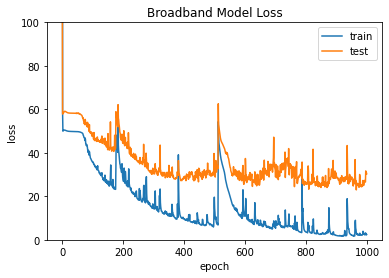

In [44]:
plot_history(
    broadband_results['loss'], 
    broadband_results['val_loss'], 
    title='Broadband Model Loss'
)

In [45]:
print(f"number of trained epochs: {np.array(broadband_results['val_loss']).argmin() + 1}")

number of trained epochs: 966


In [46]:
evalutate_model(
    HC_label_train['broadband'], 
    broadband_results['train'], 
    HC_label_test['broadband'], 
    broadband_results['test']
)

MSE_Train = 4.370
MSE_Test = 22.957
R^2score_Train = 0.911
R^2score_Test = 0.603
MSE_Train = 1.693
MAE_Test = 3.529


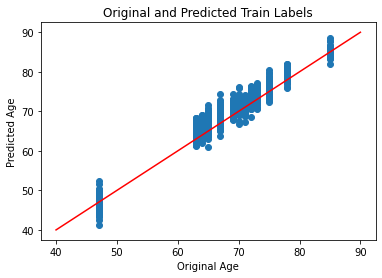

In [47]:
plot_predicted_vs_labels(
    HC_label_train['broadband'], 
    broadband_results['train'], 
    title='Train'
)

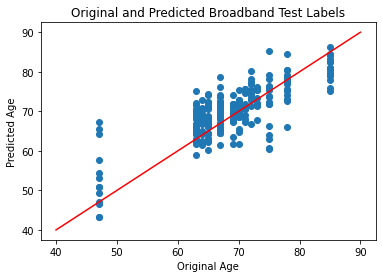

In [48]:
plot_predicted_vs_labels(
    HC_label_test['broadband'], 
    broadband_results['test'], 
    title='Broadband Test'
)
plt.savefig(f'images/{MODEL_NAME}/scatters/HC/scatter_HC_broadband.png')

#### Delta

In [49]:
delta_results = HC_results['delta']

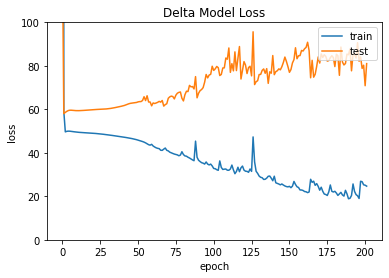

In [50]:
plot_history(
    delta_results['loss'], 
    delta_results['val_loss'], 
    title='Delta Model Loss'
)

In [51]:
print(f"number of trained epochs: {np.array(delta_results['val_loss']).argmin() + 1}")

number of trained epochs: 2


In [52]:
evalutate_model(
    HC_label_train['delta'], 
    delta_results['train'], 
    HC_label_test['delta'], 
    delta_results['test']
)

MSE_Train = 49.308
MSE_Test = 58.010
R^2score_Train = -0.010
R^2score_Test = -0.004
MSE_Train = 5.010
MAE_Test = 5.395


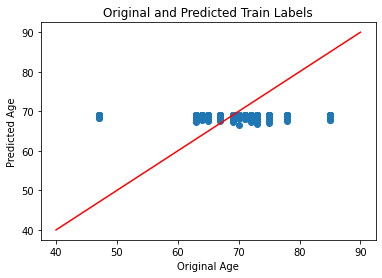

In [53]:
plot_predicted_vs_labels(
    HC_label_train['delta'], 
    delta_results['train'], 
    title='Train'
)

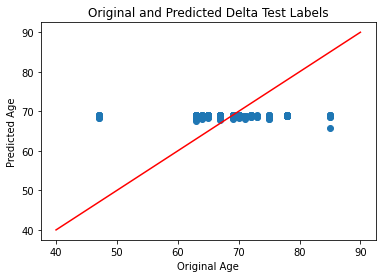

In [54]:
plot_predicted_vs_labels(
    HC_label_test['delta'],
    delta_results['test'], 
    title='Delta Test'
)
plt.savefig(f'images/{MODEL_NAME}/scatters/HC/scatter_HC_delta.png')

#### Theta

In [55]:
theta_results = HC_results['theta']

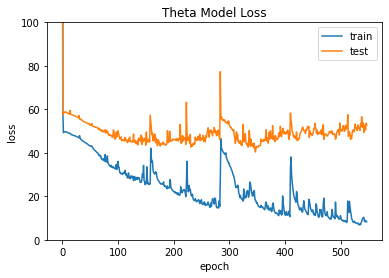

In [56]:
plot_history(
    theta_results['loss'], 
    theta_results['val_loss'], 
    title='Theta Model Loss'
)

In [57]:
print(f"number of trained epochs: {np.array(theta_results['val_loss']).argmin() + 1}")

number of trained epochs: 348


In [58]:
evalutate_model(
    HC_label_train['theta'],
    theta_results['train'], 
    HC_label_test['theta'],
    theta_results['test']
)

MSE_Train = 17.242
MSE_Test = 40.374
R^2score_Train = 0.647
R^2score_Test = 0.301
MSE_Train = 3.249
MAE_Test = 4.828


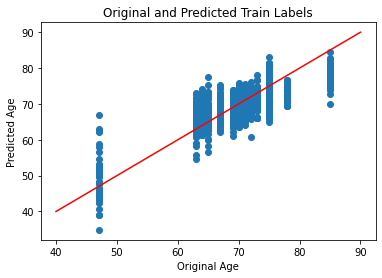

In [59]:
plot_predicted_vs_labels(
    HC_label_train['theta'],
    theta_results['train'], 
    title='Train'
)

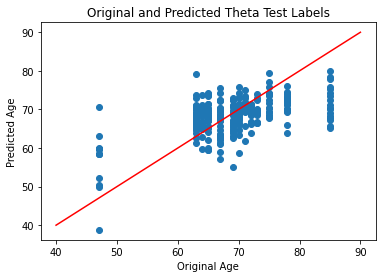

In [60]:
plot_predicted_vs_labels(
    HC_label_test['theta'], 
    theta_results['test'], 
    title='Theta Test'
)
plt.savefig(f'images/{MODEL_NAME}/scatters/HC/scatter_HC_theta.png')

#### Alpha

In [61]:
alpha_results = HC_results['alpha']

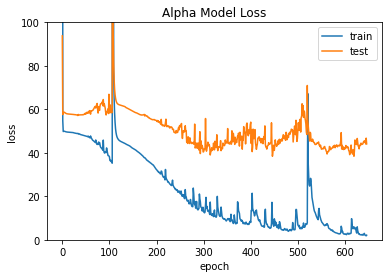

In [62]:
plot_history(
    alpha_results['loss'], 
    alpha_results['val_loss'], 
    title='Alpha Model Loss'
)

In [63]:
print(f"number of trained epochs: {np.array(alpha_results['val_loss']).argmin() + 1}")

number of trained epochs: 447


In [64]:
evalutate_model(
    HC_label_train['alpha'], 
    theta_results['train'], 
    HC_label_test['alpha'], 
    theta_results['test']
)

MSE_Train = 17.242
MSE_Test = 40.374
R^2score_Train = 0.647
R^2score_Test = 0.301
MSE_Train = 3.249
MAE_Test = 4.828


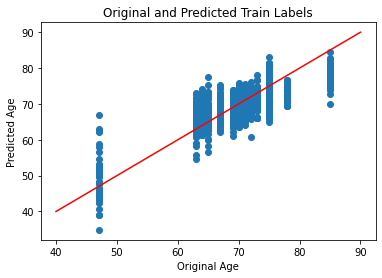

In [65]:
plot_predicted_vs_labels(
    HC_label_train['alpha'], 
    theta_results['train'], 
    title='Train'
)

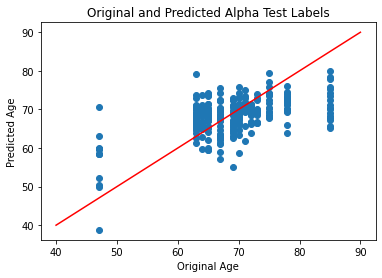

In [66]:
plot_predicted_vs_labels(
    HC_label_test['alpha'], 
    theta_results['test'], 
    title='Alpha Test'
)
plt.savefig(f'images/{MODEL_NAME}/scatters/HC/scatter_HC_alpha.png')

#### Beta

In [67]:
beta_results = HC_results['beta']

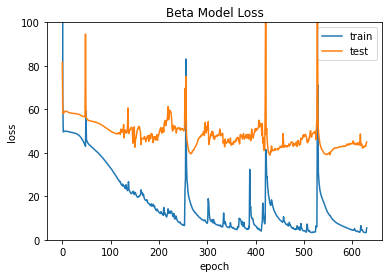

In [68]:
plot_history(
    beta_results['loss'], 
    beta_results['val_loss'], 
    title='Beta Model Loss'
)

In [69]:
print(f"number of trained epochs: {np.array(beta_results['val_loss']).argmin() + 1}")

number of trained epochs: 431


In [70]:
evalutate_model(
    HC_label_train['beta'], 
    beta_results['train'], 
    HC_label_test['beta'], 
    beta_results['test']
)

MSE_Train = 17.194
MSE_Test = 38.921
R^2score_Train = 0.648
R^2score_Test = 0.326
MSE_Train = 3.233
MAE_Test = 4.727


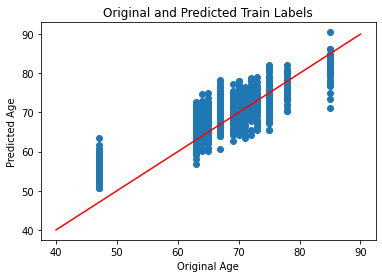

In [71]:
plot_predicted_vs_labels(
    HC_label_train['beta'], 
    beta_results['train'], 
    title='Train'
)

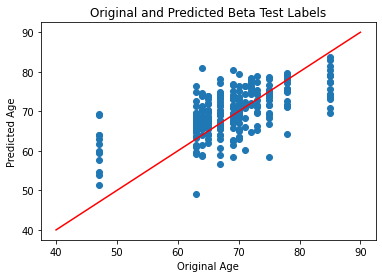

In [72]:
plot_predicted_vs_labels(
    HC_label_test['beta'], 
    beta_results['test'], 
    title='Beta Test'
)
plt.savefig(f'images/{MODEL_NAME}/scatters/HC/scatter_HC_beta.png')

#### Gamma

In [73]:
gamma_results = HC_results['gamma']

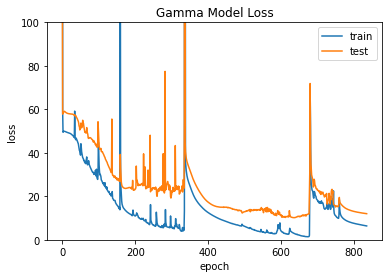

In [74]:
plot_history(
    gamma_results['loss'], 
    gamma_results['val_loss'], 
    title='Gamma Model Loss'
)

In [75]:
print(f"number of trained epochs: {np.array(gamma_results['val_loss']).argmin() + 1}")

number of trained epochs: 636


In [76]:
evalutate_model(
    HC_label_train['gamma'], 
    gamma_results['train'], 
    HC_label_test['gamma'], 
    gamma_results['test']
)

MSE_Train = 3.102
MSE_Test = 10.184
R^2score_Train = 0.936
R^2score_Test = 0.824
MSE_Train = 1.386
MAE_Test = 2.434


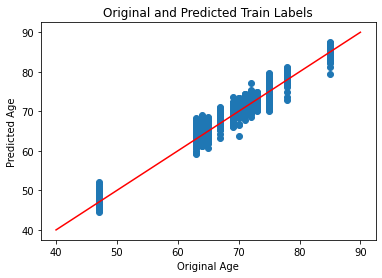

In [77]:
plot_predicted_vs_labels(
    HC_label_train['gamma'], 
    gamma_results['train'], 
    title='Train'
)

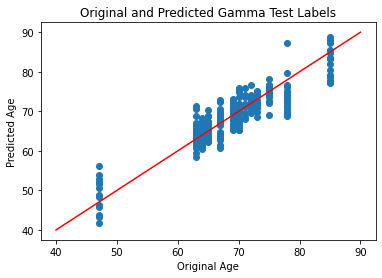

In [78]:
plot_predicted_vs_labels(
    HC_label_test['gamma'], 
    gamma_results['test'], 
    title='Gamma Test'
)
plt.savefig(f'images/{MODEL_NAME}/scatters/HC/scatter_HC_gamma.png')

### Models for PD

In [79]:
PD_med = dict()
for key in PD: 
    PD_med[key] = np.zeros((PD[key].shape[0], PD[key].shape[1], PD[key].shape[2] + 1))
    PD_med[key][:, :, :PD[key].shape[2]] = PD[key]
    for i in range(len(PD_med[key])):
        PD_med[key][i, :, -1] = PD_labels['taken_med'][i]

In [80]:
PD_train = {}; PD_test = {}; PD_label_train = {}; PD_label_test = {};
for key in PD_med:
    X_train, X_test, y_train, y_test = train_test_split(PD_med[key], PD_labels['age'], test_size=0.2, random_state=SEED)
    PD_train[key] = X_train
    PD_test[key] = X_test
    PD_label_train[key] = y_train
    PD_label_test[key] = y_test

In [81]:
try:
    with open(f'results/{MODEL_NAME}/PD_results.pickle', 'rb') as f:
        PD_results = pickle.load(f)
except Exception:
    PD_results = run_model(MODEL_FUNC, MODEL_NAME, 'PD', PD_train, PD_test, PD_label_train, PD_label_test)

In [82]:
with open(f'results/{MODEL_NAME}/PD_results.pickle', 'wb+') as f:
    pickle.dump(PD_results, f)

#### BroadBand

In [83]:
broadband_results = PD_results['broadband']

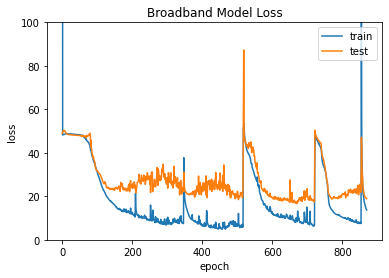

In [84]:
plot_history(
    broadband_results['loss'], 
    broadband_results['val_loss'], 
    title='Broadband Model Loss'
)

In [85]:
print(f"number of trained epochs: {np.array(broadband_results['val_loss']).argmin() + 1}")

number of trained epochs: 670


In [86]:
evalutate_model(
    PD_label_train['broadband'], 
    broadband_results['train'], 
    PD_label_test['broadband'], 
    broadband_results['test']
)

MSE_Train = 8.549
MSE_Test = 16.679
R^2score_Train = 0.819
R^2score_Test = 0.654
MSE_Train = 2.307
MAE_Test = 3.230


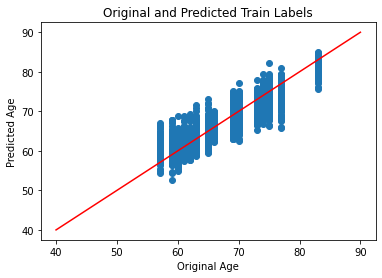

In [87]:
plot_predicted_vs_labels(
    PD_label_train['broadband'], 
    broadband_results['train'], 
    title='Train'
)

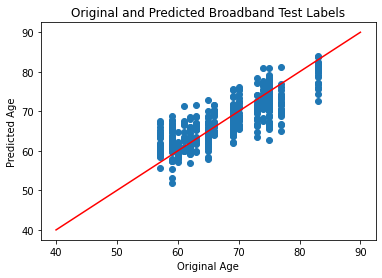

In [88]:
plot_predicted_vs_labels(
    PD_label_test['broadband'], 
    broadband_results['test'], 
    title='Broadband Test'
)
plt.savefig(f'images/{MODEL_NAME}/scatters/PD/scatter_PD_broadband.png')

#### Delta

In [89]:
delta_results = PD_results['delta']

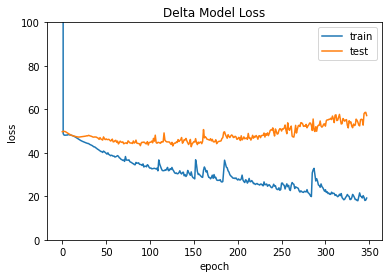

In [90]:
plot_history(
    delta_results['loss'], 
    delta_results['val_loss'], 
    title='Delta Model Loss'
)

In [91]:
print(f"number of trained epochs: {np.array(delta_results['val_loss']).argmin() + 1}")

number of trained epochs: 148


In [92]:
evalutate_model(
    PD_label_train['delta'], 
    delta_results['train'], 
    PD_label_test['delta'], 
    delta_results['test']
)

MSE_Train = 28.162
MSE_Test = 42.800
R^2score_Train = 0.403
R^2score_Test = 0.112
MSE_Train = 4.231
MAE_Test = 5.249


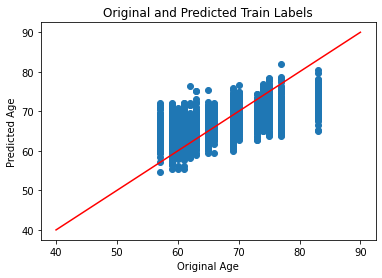

In [93]:
plot_predicted_vs_labels(
    PD_label_train['delta'], 
    delta_results['train'], 
    title='Train'
)

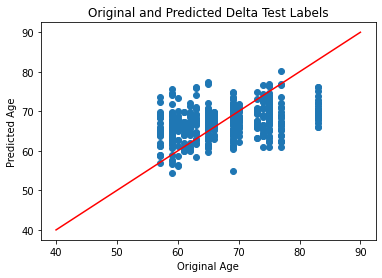

In [94]:
plot_predicted_vs_labels(
    PD_label_test['delta'], 
    delta_results['test'], 
    title='Delta Test'
)
plt.savefig(f'images/{MODEL_NAME}/scatters/PD/scatter_PD_delta.png')

#### Theta

In [95]:
theta_results = PD_results['theta']

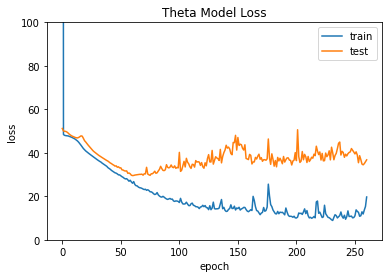

In [96]:
plot_history(
    theta_results['loss'], 
    theta_results['val_loss'], 
    title='Theta Model Loss'
)

In [97]:
print(f"number of trained epochs: {np.array(theta_results['val_loss']).argmin() + 1}")

number of trained epochs: 61


In [98]:
evalutate_model(
    PD_label_train['theta'], 
    theta_results['train'], 
    PD_label_test['theta'], 
    theta_results['test']
)

MSE_Train = 24.092
MSE_Test = 29.539
R^2score_Train = 0.489
R^2score_Test = 0.387
MSE_Train = 3.944
MAE_Test = 4.345


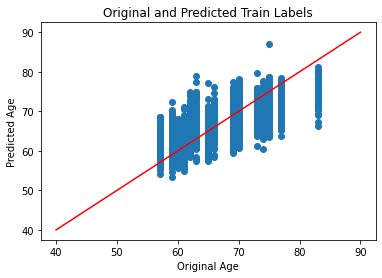

In [99]:
plot_predicted_vs_labels(
    PD_label_train['theta'], 
    theta_results['train'], 
    title='Train'
)

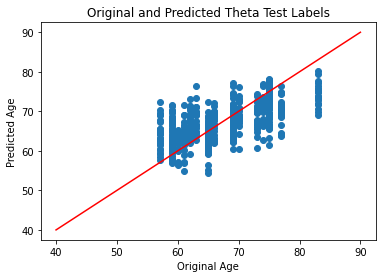

In [100]:
plot_predicted_vs_labels(
    PD_label_test['theta'], 
    theta_results['test'], 
    title='Theta Test'
)
plt.savefig(f'images/{MODEL_NAME}/scatters/PD/scatter_PD_theta.png')

#### Alpha

In [101]:
alpha_results = PD_results['alpha']

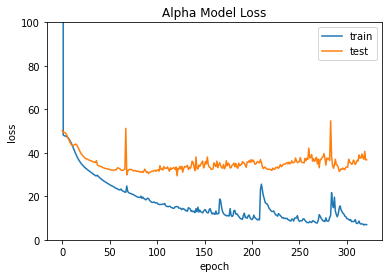

In [102]:
plot_history(
    alpha_results['loss'], 
    alpha_results['val_loss'], 
    title='Alpha Model Loss'
)

In [103]:
print(f"number of trained epochs: {np.array(alpha_results['val_loss']).argmin() + 1}")

number of trained epochs: 122


In [104]:
evalutate_model(
    PD_label_train['alpha'], 
    alpha_results['train'], 
    PD_label_test['alpha'], 
    alpha_results['test']
)

MSE_Train = 13.829
MSE_Test = 29.414
R^2score_Train = 0.707
R^2score_Test = 0.389
MSE_Train = 2.917
MAE_Test = 4.300


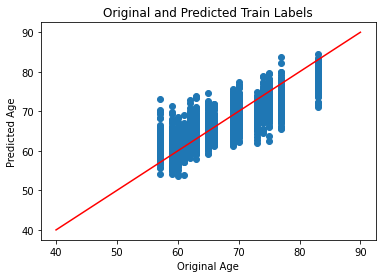

In [105]:
plot_predicted_vs_labels(
    PD_label_train['alpha'], 
    alpha_results['train'], 
    title='Train'
)

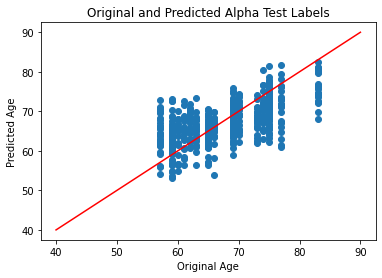

In [106]:
plot_predicted_vs_labels(
    PD_label_test['alpha'], 
    alpha_results['test'],
    title='Alpha Test'
)
plt.savefig(f'images/{MODEL_NAME}/scatters/PD/scatter_PD_alpha.png')

#### Beta

In [107]:
beta_results = PD_results['beta']

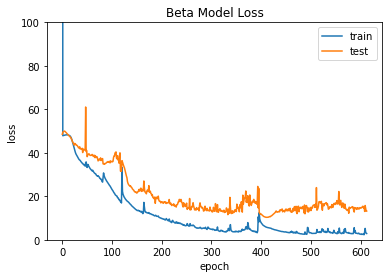

In [108]:
plot_history(
    beta_results['loss'], 
    beta_results['val_loss'], 
    title='Beta Model Loss'
)

In [109]:
print(f"number of trained epochs: {np.array(beta_results['val_loss']).argmin() + 1}")

number of trained epochs: 413


In [110]:
evalutate_model(
    PD_label_train['beta'], 
    beta_results['train'], 
    PD_label_test['beta'], 
    beta_results['test']
)

MSE_Train = 4.861
MSE_Test = 10.318
R^2score_Train = 0.897
R^2score_Test = 0.786
MSE_Train = 1.705
MAE_Test = 2.369


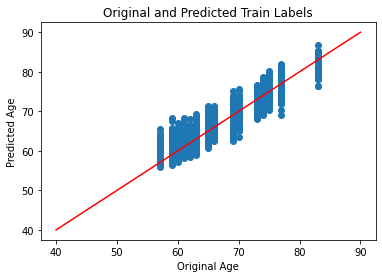

In [111]:
plot_predicted_vs_labels(
    PD_label_train['beta'], 
    beta_results['train'], 
    title='Train'
)

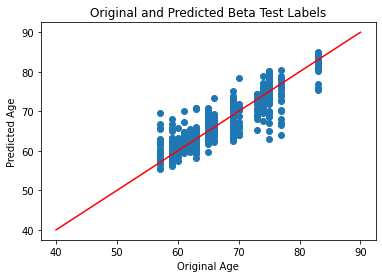

In [112]:
plot_predicted_vs_labels(
    PD_label_test['beta'], 
    beta_results['test'],
    title='Beta Test'
)
plt.savefig(f'images/{MODEL_NAME}/scatters/PD/scatter_PD_beta.png')

#### Gamma

In [113]:
gamma_results = PD_results['gamma']

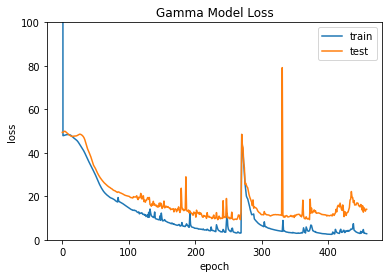

In [114]:
plot_history(
    gamma_results['loss'], 
    gamma_results['val_loss'], 
    title='Gamma Model Loss'
)

In [115]:
print(f"number of trained epochs: {np.array(gamma_results['val_loss']).argmin() + 1}")

number of trained epochs: 259


In [116]:
evalutate_model(
    PD_label_train['gamma'], 
    gamma_results['train'], 
    PD_label_test['gamma'], 
    gamma_results['test']
)

MSE_Train = 3.424
MSE_Test = 9.204
R^2score_Train = 0.927
R^2score_Test = 0.809
MSE_Train = 1.446
MAE_Test = 2.309


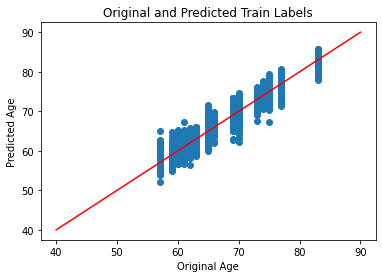

In [117]:
plot_predicted_vs_labels(
    PD_label_train['gamma'], 
    gamma_results['train'], 
    title='Train'
)

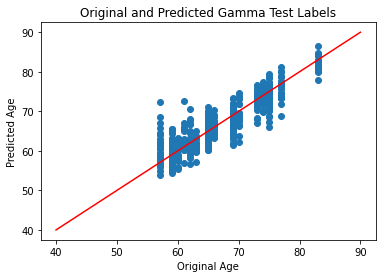

In [118]:
plot_predicted_vs_labels(
    PD_label_test['gamma'], 
    gamma_results['test'],
    title='Gamma Test'
)
plt.savefig(f'images/{MODEL_NAME}/scatters/PD/scatter_PD_gamma.png')

## Analysis

### Bar Chart

In [119]:
def model_errors_barchart(names, HC_means, PD_means, HC_stds, PD_stds, HC_baseline, PD_baseline, title):
    x_pos = np.arange(len(names))
    width = 0.35
    
    fig, ax = plt.subplots()
    ax.bar(x_pos - width / 2, HC_means, width, yerr=HC_stds, capsize=5, label='HC')
    ax.bar(x_pos + width / 2, PD_means, width, yerr=PD_stds, capsize=5, label='PD')
    
    plt.plot([-0.5, 5.5], [HC_baseline, HC_baseline], '--', label='HC baseline')
    plt.plot([-0.5, 5.5], [PD_baseline, PD_baseline], '--', label='PD baseline')
    
    ax.set_xlabel('Sub-Bands')
    ax.set_ylabel('MAE')
    
    ax.set_xticks(x_pos)
    ax.set_xticklabels(names)
    
    ax.legend(loc=1)
    
    ax.set_title(title)
    ax.yaxis.grid(True)

    # Save the figure and show
    plt.tight_layout()

In [120]:
names = ['broadband', 'delta', 'theta', 'alpha', 'beta', 'gamma']

#### HC

In [121]:
HC_means = dict()
HC_stds = dict()
for key in HC_results:
    diff = HC_results[key]['test'] - HC_label_test[key]
    diff = np.abs(diff)
    HC_means[key] = np.mean(diff)
    HC_stds[key] = np.std(diff) / np.sqrt(len(diff))

In [122]:
HC_mean = np.mean(HC_label_train['alpha'])
HC_mean = np.ones_like(HC_label_train['alpha']) * HC_mean
HC_baseline = mean_absolute_error(HC_label_train['alpha'], HC_mean)
HC_baseline

5.0083237

#### PD

In [123]:
PD_means = dict()
PD_stds = dict()
for key in PD_results:
    diff = PD_results[key]['test'] - PD_label_test[key]
    diff = np.abs(diff)
    PD_means[key] = np.mean(diff)
    PD_stds[key] = np.std(diff) / np.sqrt(len(diff))

In [124]:
PD_mean = np.mean(PD_label_train['alpha'])
PD_mean = np.ones_like(PD_label_train['alpha']) * PD_mean
PD_baseline = mean_absolute_error(PD_label_train['alpha'], PD_mean)
PD_baseline

5.824054

#### Plot

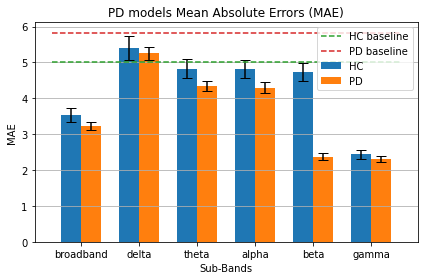

In [125]:
model_errors_barchart(
    names, 
    [HC_means[key] for key in names],
    [PD_means[key] for key in names],
    [HC_stds[key] for key in names],
    [PD_stds[key] for key in names],
    HC_baseline, PD_baseline,
    'PD models Mean Absolute Errors (MAE)',
)

plt.savefig(f'images/{MODEL_NAME}/HC_PD_barchart.png')

### Saliency Map

In [126]:
import seaborn as sns

In [127]:
def saliency_map(model, data, output):
    with tf.GradientTape() as tape:
        tape.watch(data)
        predictions = model(data)
        loss = tf.metrics.mse(predictions, output)

    # Get the gradients of the loss w.r.t to the input image.
    gradient = tape.gradient(loss, data)
    g_abs = tf.math.abs(gradient).numpy()
    g_min, g_max = g_abs.min(), g_abs.max()
    g_norm = (g_abs - g_min) / (g_max - g_min + np.finfo(float).eps)
    g_norm = g_norm.reshape((g_norm.shape[1:3]))
    return g_norm

In [128]:
def get_saliency(model, inp, out):
    inp = inp.reshape([1, *inp.shape])
    inp = tf.convert_to_tensor(inp)
    out = tf.convert_to_tensor(out)
    return saliency_map(model, inp, out) 

In [129]:
def saliency_heat_map(saliency, title):
    plt.figure(figsize=(10, 10))
    ax = sns.heatmap(saliency.T[:27])
    ax.set(xlabel='Time', ylabel='Channel', title=title)

    xticks = np.linspace(0, 500, 11, dtype=np.int)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks * 2)

    yticks = ['FP1', 'FPZ', 'FP2', 'F7', 'F3', 'FZ', 'F4', 'F8', 'FC5', 'FC6', 'T7', 'C3', 'CZ', 'C4', 'T8', 'CP5', 'CP6', 'P7', 'P3', 'PZ', 'P4', 'P8', 'PO5', 'PO6', 'O1', 'OZ', 'O2']
    ax.set_yticklabels(yticks)
    plt.yticks(rotation=0) 

In [130]:
def saliency_heat_map_PD(saliency, title):
    plt.figure(figsize=(10, 10))
    ax = sns.heatmap(saliency.T)
    ax.set(xlabel='Time', ylabel='Channel', title=title)

    xticks = np.linspace(0, 500, 11, dtype=np.int)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks * 2)

    yticks = ['FP1', 'FPZ', 'FP2', 'F7', 'F3', 'FZ', 'F4', 'F8', 'FC5', 'FC6', 'T7', 'C3', 'CZ', 'C4', 'T8', 'CP5', 'CP6', 'P7', 'P3', 'PZ', 'P4', 'P8', 'PO5', 'PO6', 'O1', 'OZ', 'O2', 'taken_med']
    ax.set_yticklabels(yticks)
    plt.yticks(rotation=0) 

#### HC

##### Min

In [131]:
min_index = HC_label_test['broadband'].argmin()
max_index = HC_label_test['broadband'].argmax()

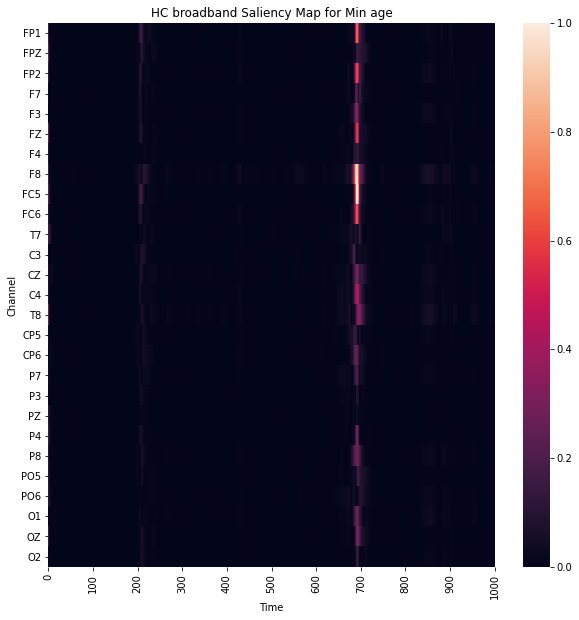

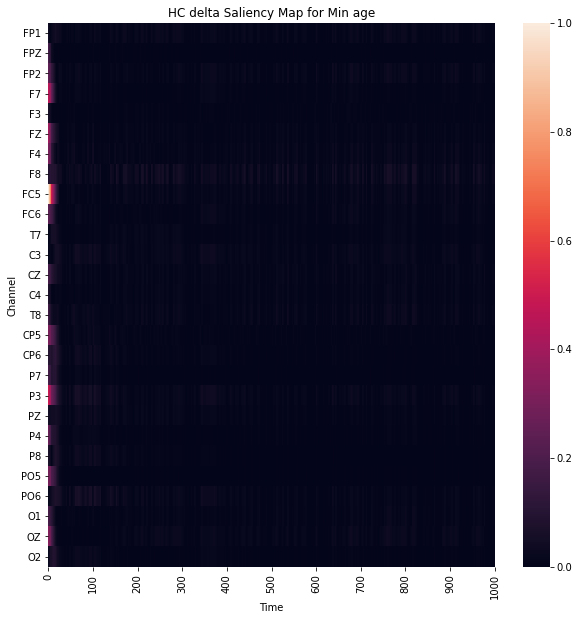

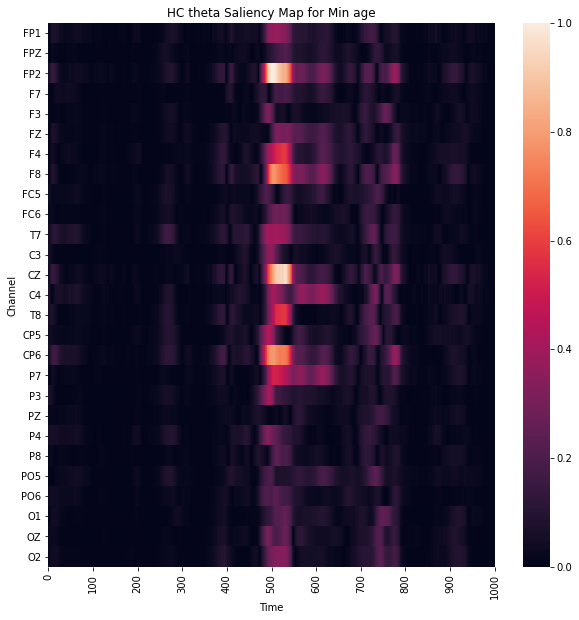

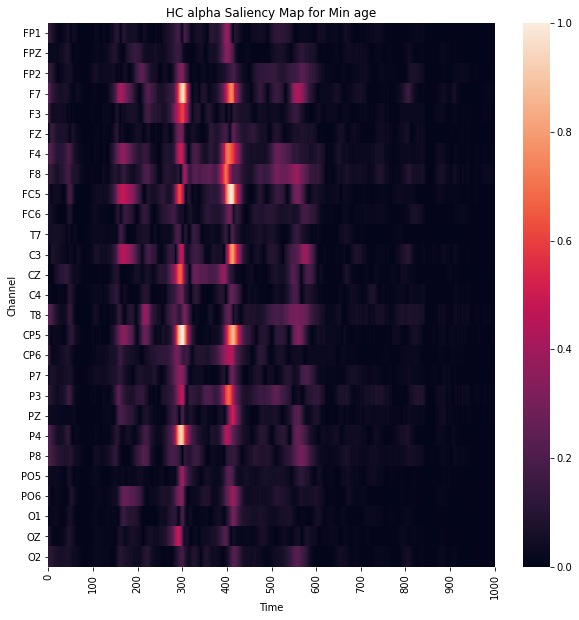

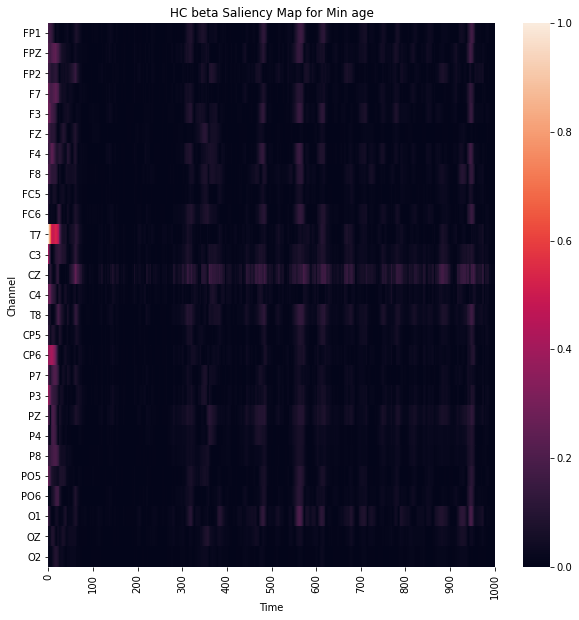

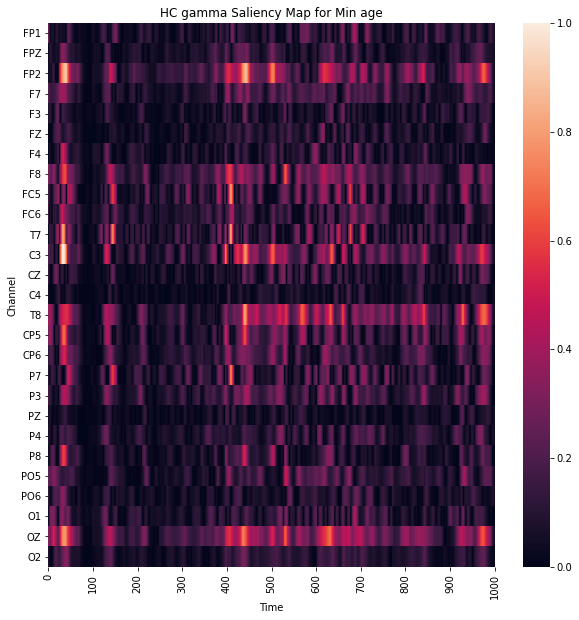

In [132]:
for name in names: 
    model = load_model(f'models/{MODEL_NAME}/HC/{name}.h5')
    saliency = get_saliency(
        model, HC_test[name][min_index], HC_label_test[name][min_index].astype('float32')
    )
    saliency_heat_map(saliency, f'HC {name} Saliency Map for Min age')
    plt.savefig(f'images/{MODEL_NAME}/saliencies/hc/min/HC_{name}_min_saliency.png')

##### Max

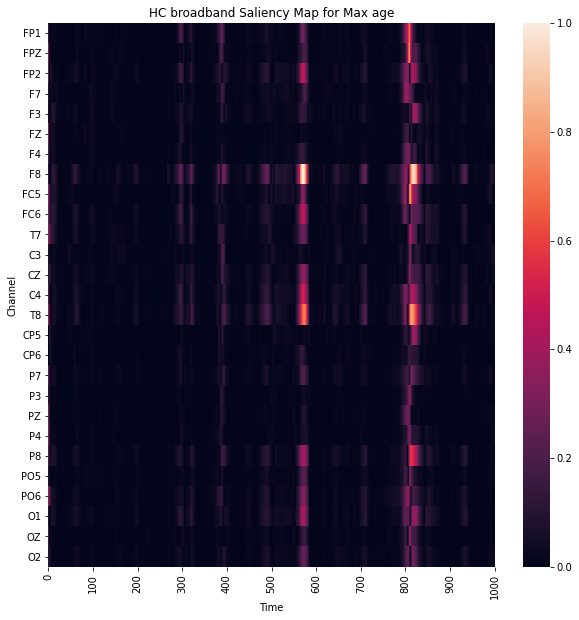

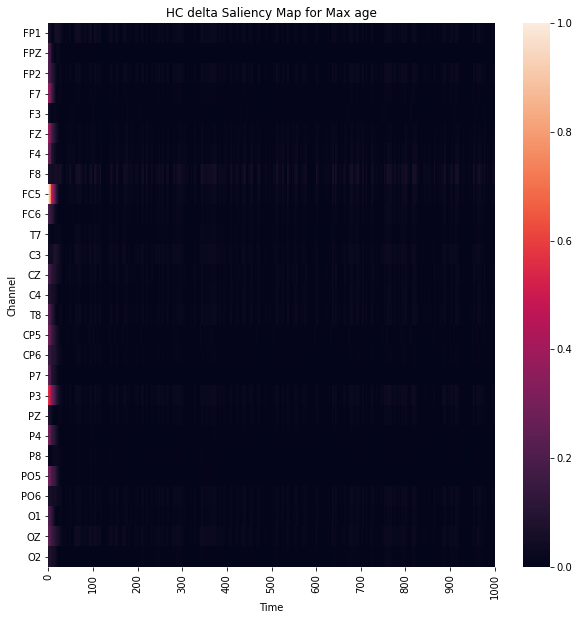

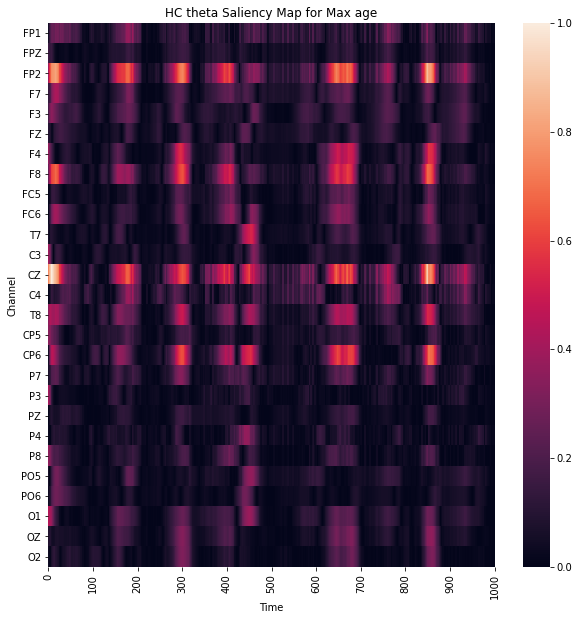

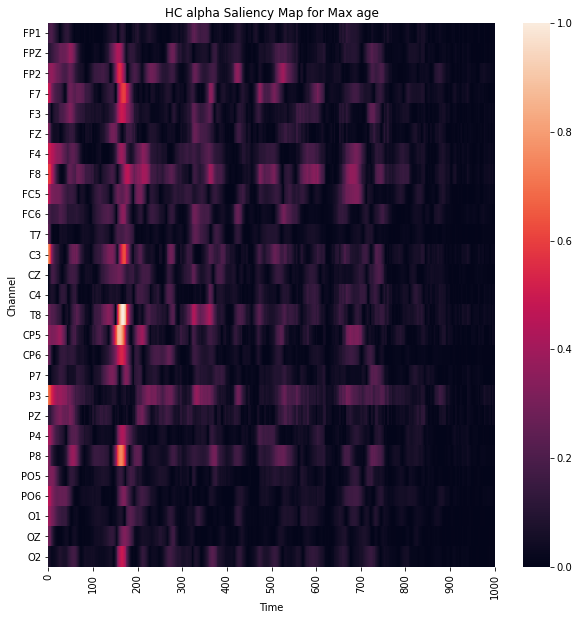

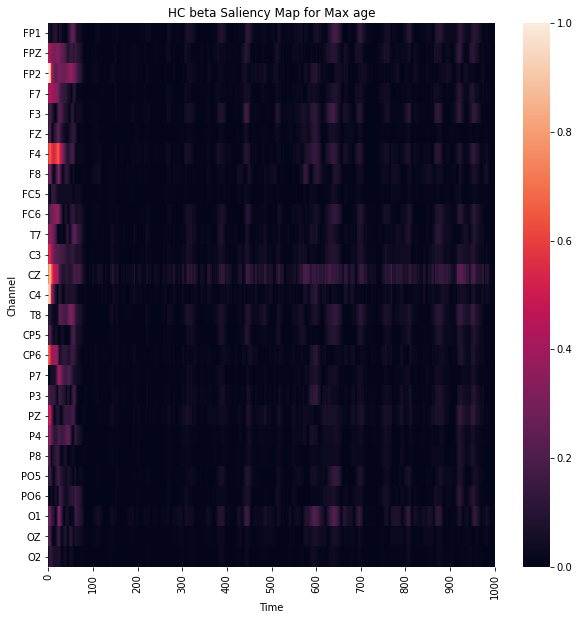

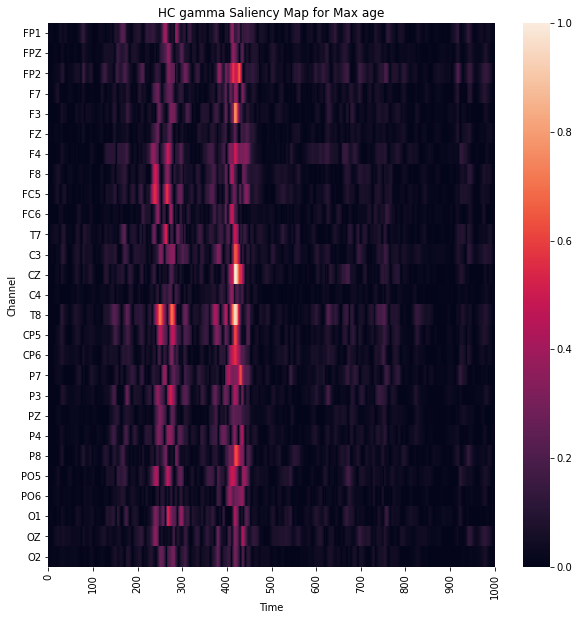

In [133]:
for name in names: 
    model = load_model(f'models/{MODEL_NAME}/HC/{name}.h5')
    saliency = get_saliency(
        model, HC_test[name][max_index], HC_label_test[name][max_index].astype('float32')
    )
    saliency_heat_map(saliency, f'HC {name} Saliency Map for Max age')
    plt.savefig(f'images/{MODEL_NAME}/saliencies/hc/max/HC_{name}_max_saliency.png')

#### PD

##### Min

In [134]:
min_val = PD_label_test['broadband'].min()
max_val = PD_label_test['broadband'].max()

In [135]:
min_indexes = PD_label_test['broadband'] == min_val
min_indexes = min_indexes[:, 0]

In [136]:
taken_med = PD_test['broadband'][:, :, 27].sum(axis=1) > 0

In [137]:
min_index_on = np.logical_and(taken_med, min_indexes).argmax()
min_index_off = np.logical_and(~taken_med, min_indexes).argmax()

(500, 28)
(500, 28)
(500, 28)
(500, 28)
(500, 28)
(500, 28)


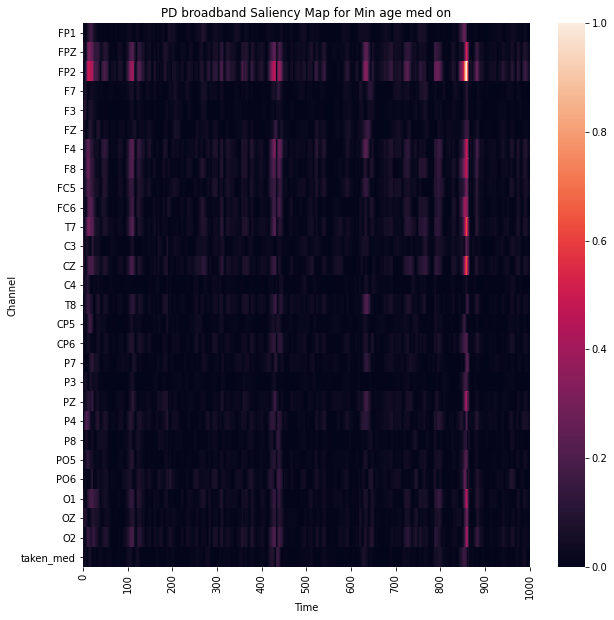

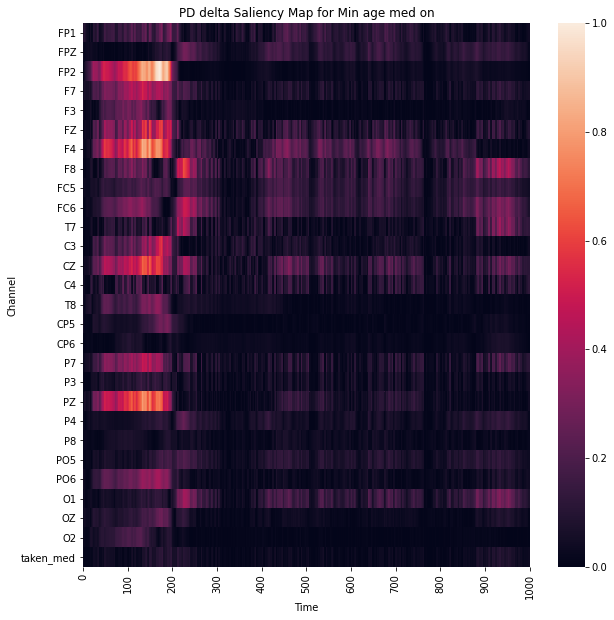

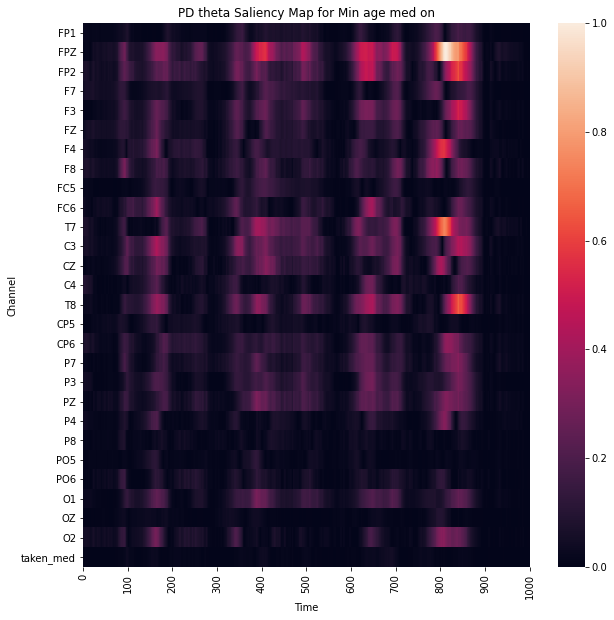

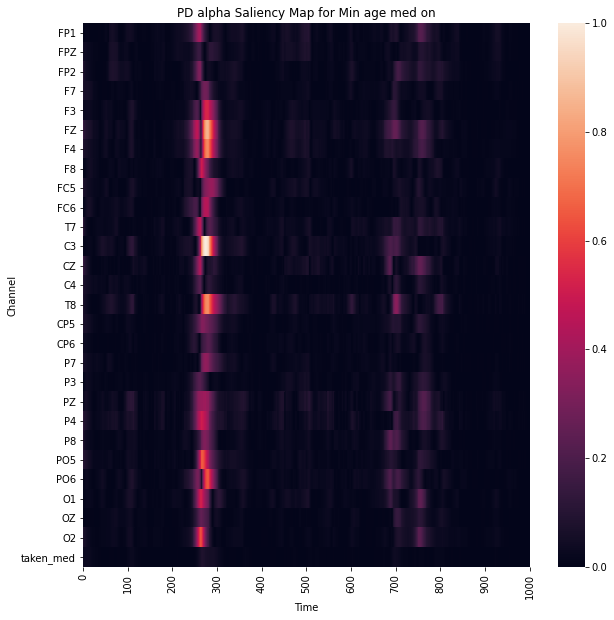

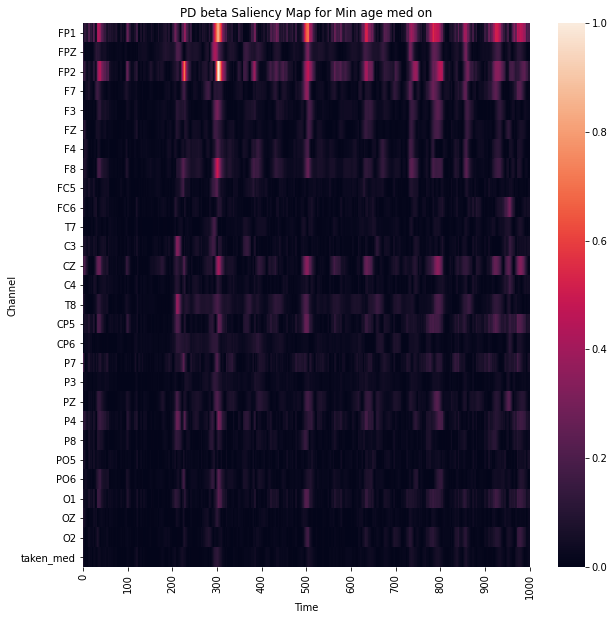

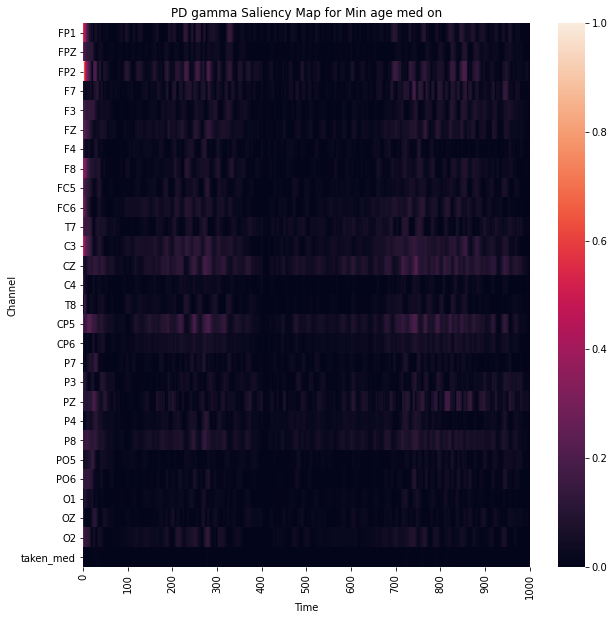

In [138]:
for name in names: 
    model = load_model(f'models/{MODEL_NAME}/PD/{name}.h5')
    saliency = get_saliency(
        model, PD_test[name][min_index_on], PD_label_test[name][min_index_on].astype('float32')
    )
    saliency_heat_map_PD(saliency, f'PD {name} Saliency Map for Min age med on')
    plt.savefig(f'images/{MODEL_NAME}/saliencies/pd_on/min/PD_{name}_min_on_saliency.png')

(500, 28)
(500, 28)
(500, 28)
(500, 28)
(500, 28)
(500, 28)


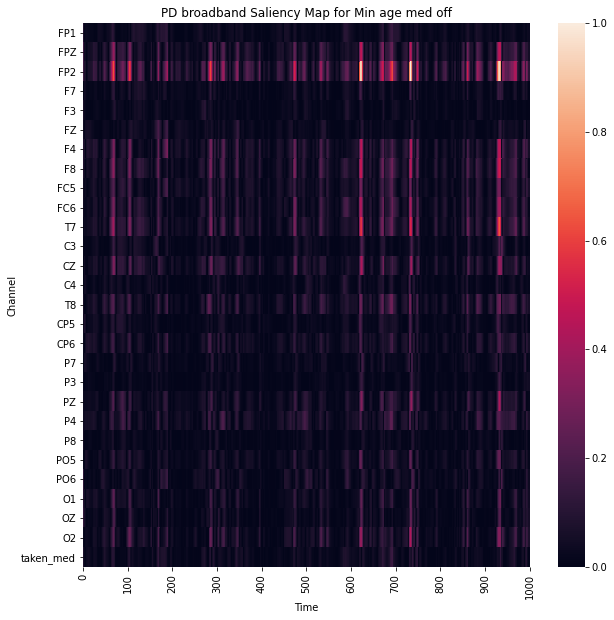

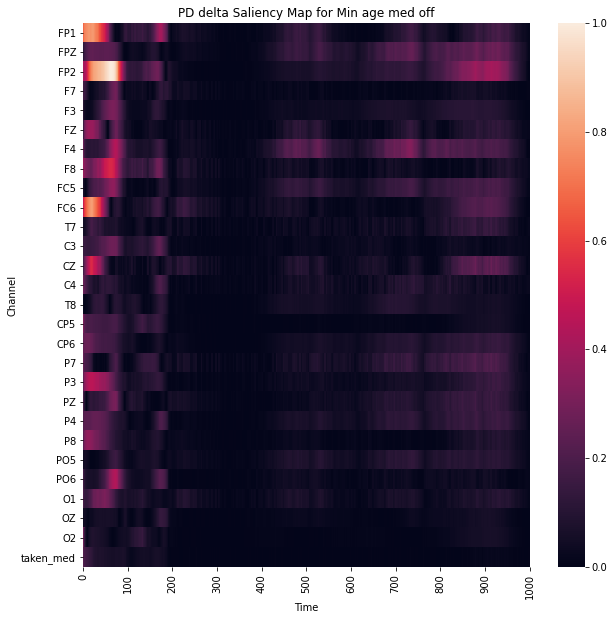

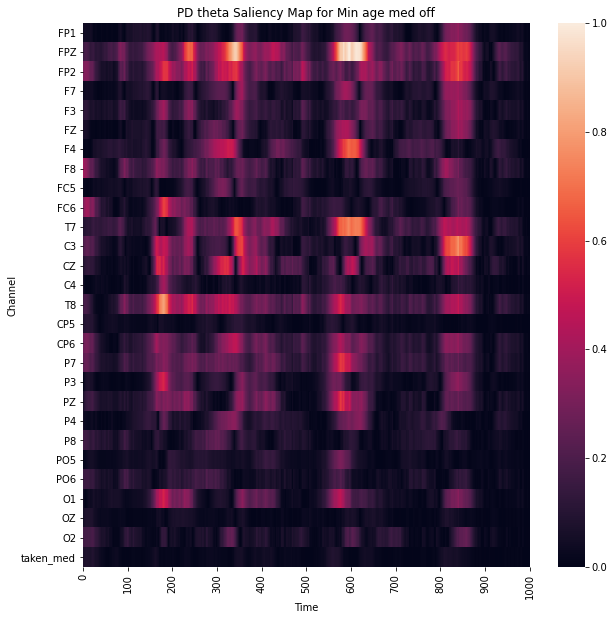

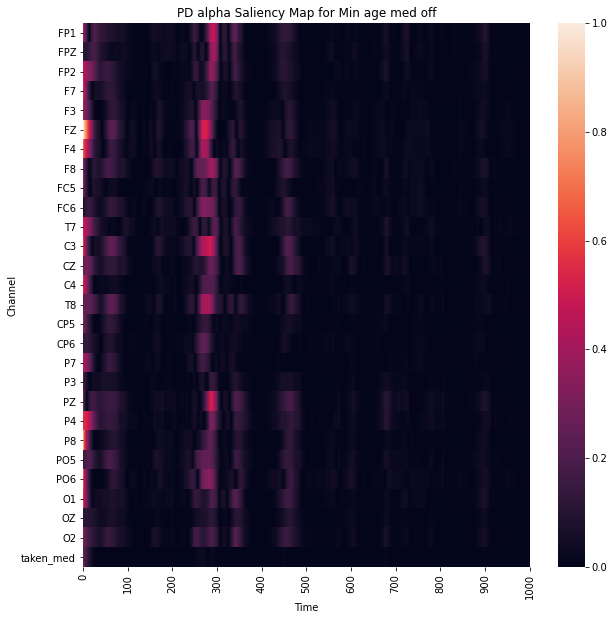

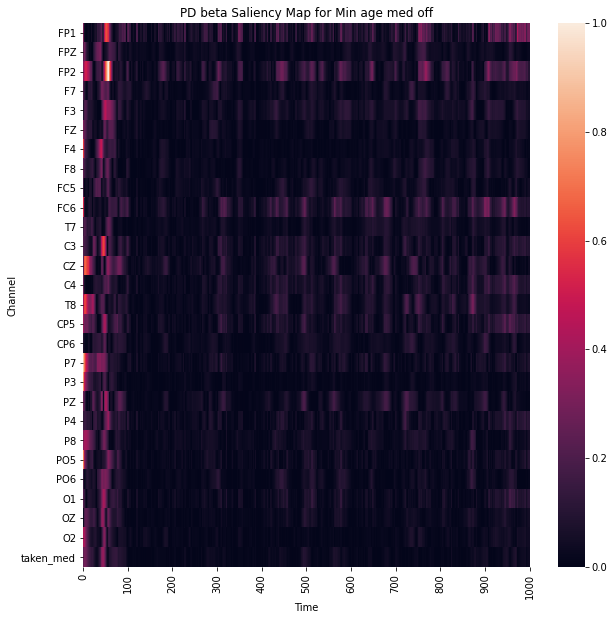

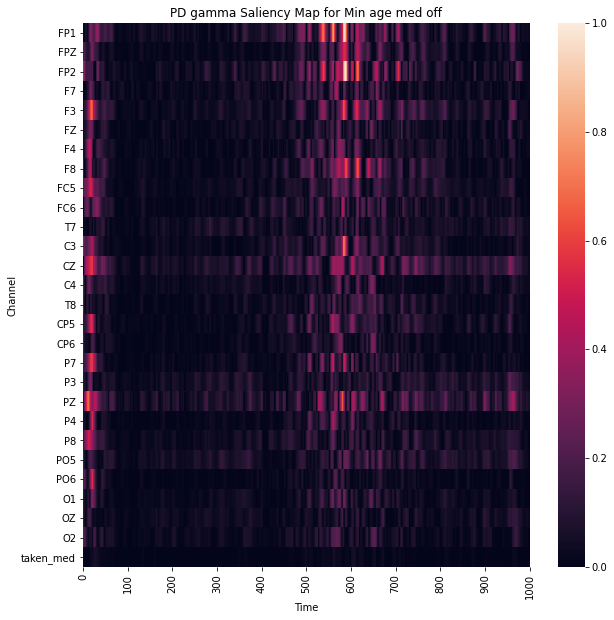

In [139]:
for name in names: 
    model = load_model(f'models/{MODEL_NAME}/PD/{name}.h5')
    saliency = get_saliency(
        model, PD_test[name][min_index_off], PD_label_test[name][min_index_off].astype('float32')
    )
    saliency_heat_map_PD(saliency, f'PD {name} Saliency Map for Min age med off')
    plt.savefig(f'images/{MODEL_NAME}/saliencies/pd_on/min/PD_{name}_min_off_saliency.png')

##### Max

In [140]:
max_indexes = PD_label_test['broadband'] == max_val
max_indexes = max_indexes[:, 0]

In [141]:
max_index_on = np.logical_and(taken_med, max_indexes).argmax()
max_index_off = np.logical_and(~taken_med, max_indexes).argmax()

(500, 28)
(500, 28)
(500, 28)
(500, 28)
(500, 28)
(500, 28)


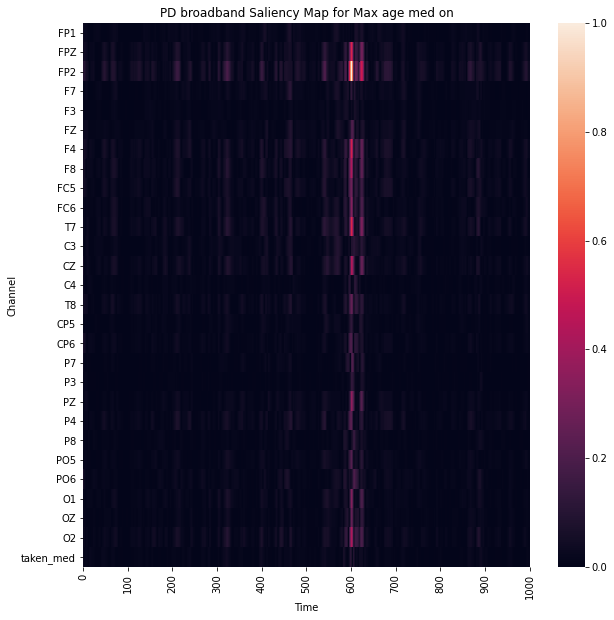

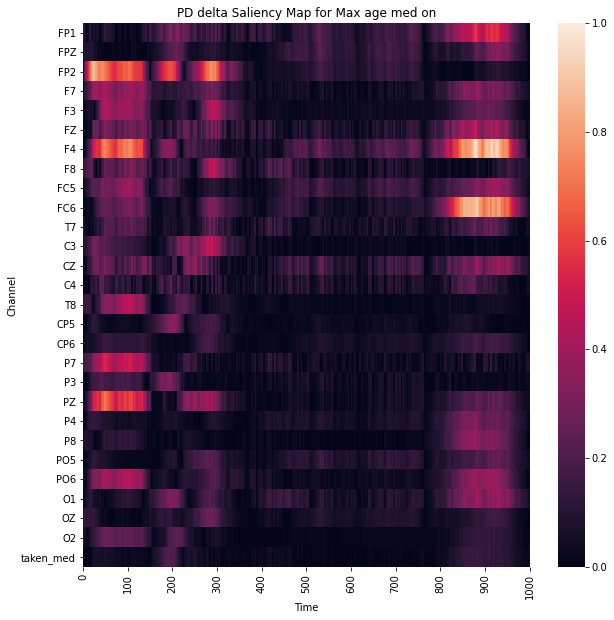

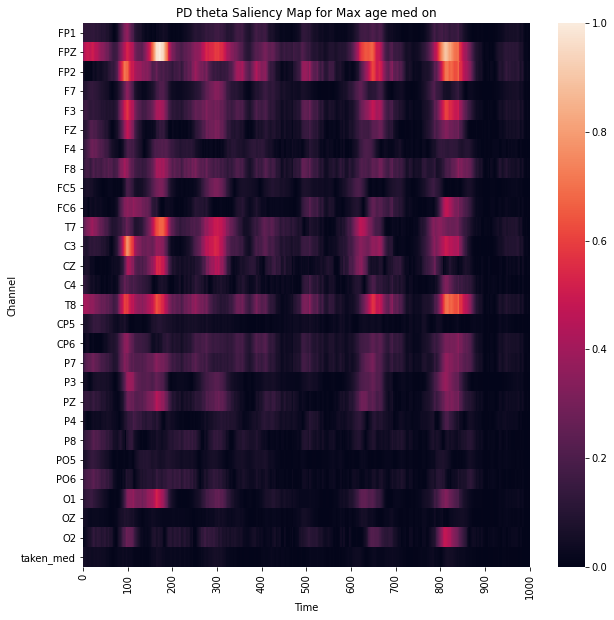

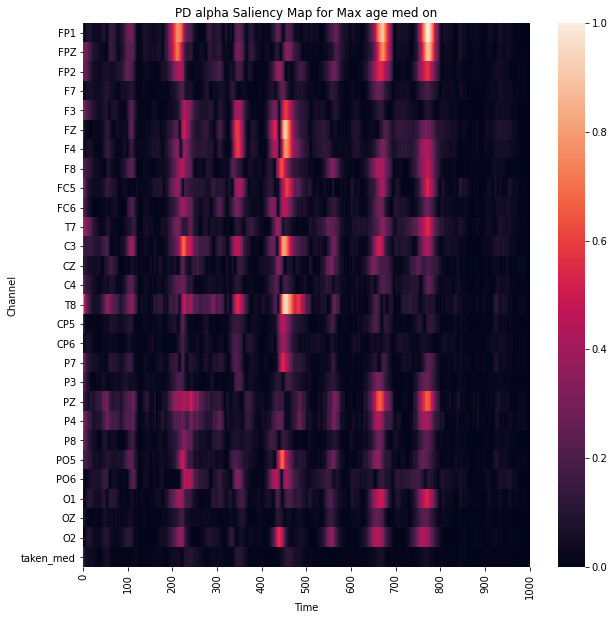

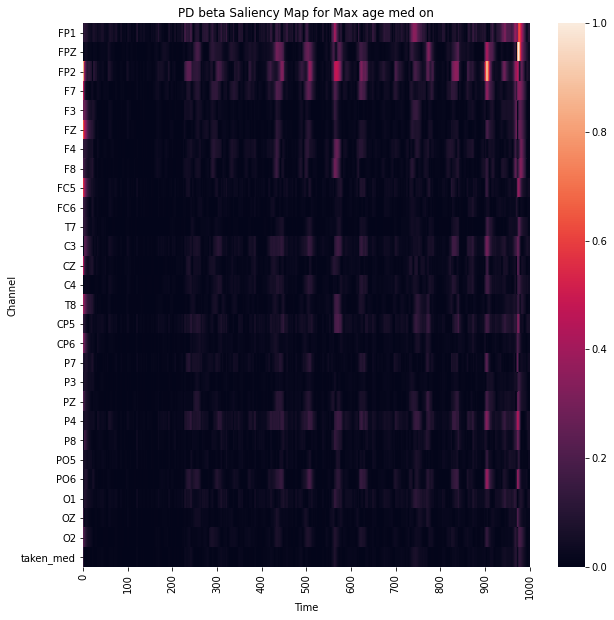

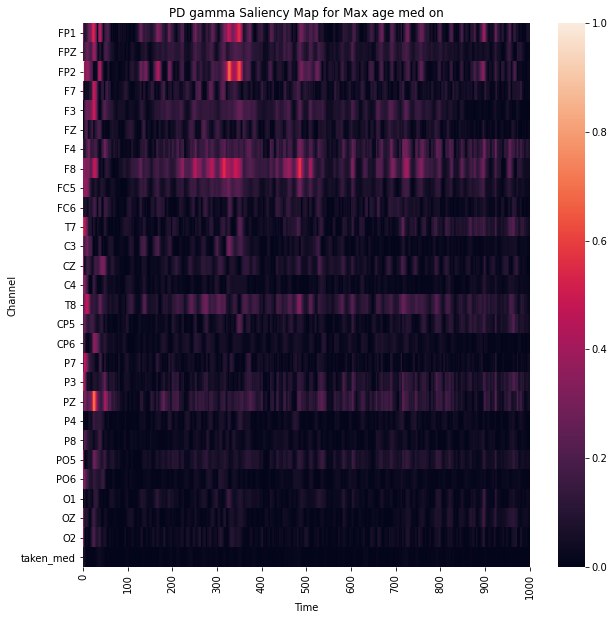

In [142]:
for name in names: 
    model = load_model(f'models/{MODEL_NAME}/PD/{name}.h5')
    saliency = get_saliency(
        model, PD_test[name][max_index_on], PD_label_test[name][max_index_on].astype('float32')
    )
    saliency_heat_map_PD(saliency, f'PD {name} Saliency Map for Max age med on')
    plt.savefig(f'images/{MODEL_NAME}/saliencies/pd_on/max/PD_{name}_max_on_saliency.png')

(500, 28)
(500, 28)
(500, 28)
(500, 28)
(500, 28)
(500, 28)


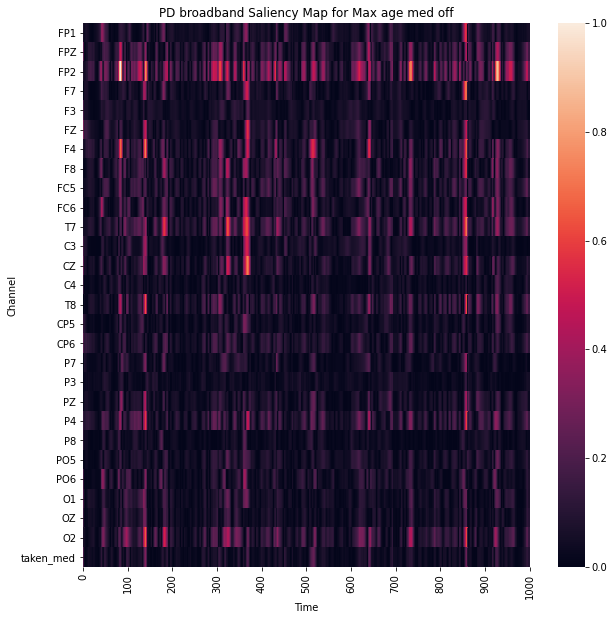

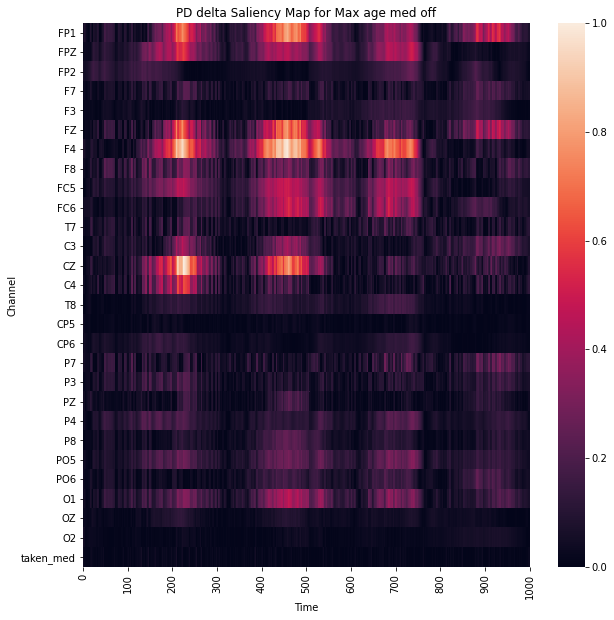

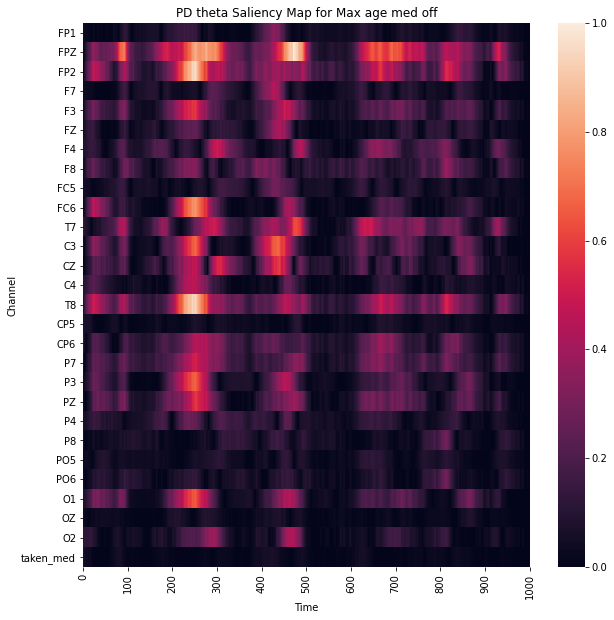

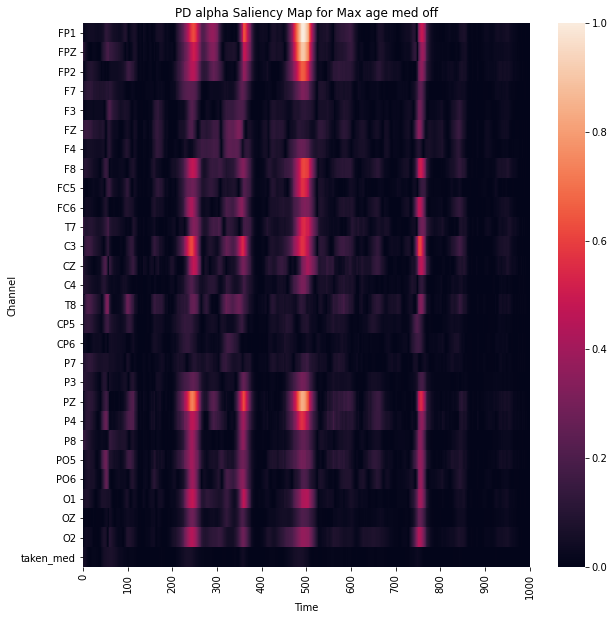

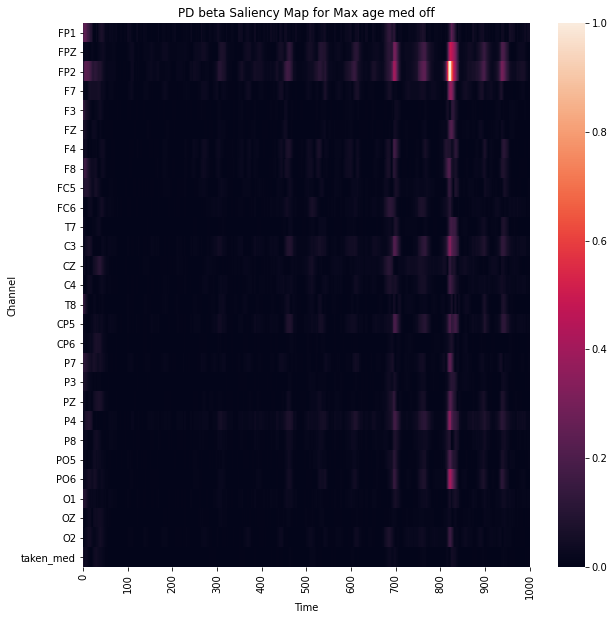

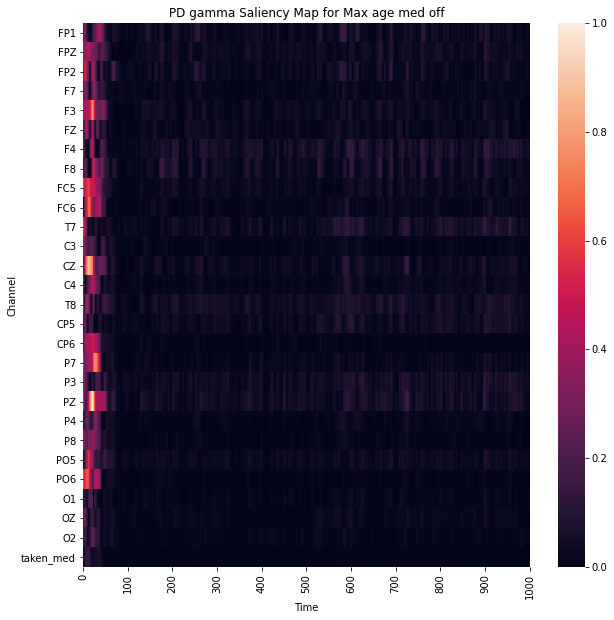

In [143]:
for name in names: 
    model = load_model(f'models/{MODEL_NAME}/PD/{name}.h5')
    saliency = get_saliency(
        model, PD_test[name][max_index_off], PD_label_test[name][max_index_off].astype('float32')
    )
    saliency_heat_map_PD(saliency, f'PD {name} Saliency Map for Max age med off')
    plt.savefig(f'images/{MODEL_NAME}/saliencies/pd_off/max/PD_{name}_max_off_saliency.png')

### Test Sensors' Errors

#### Functions

In [144]:
from sklearn.preprocessing import MinMaxScaler
import matplotlib.image as mpimg

In [145]:
def test_sensor_error(model, x_test, y_test):
    results = list()
    for i in range(x_test.shape[2]):
        inp = np.zeros_like(x_test)
        inp[:, :, i] = x_test[:, :, i]
        loss, accuracy = model.evaluate(inp, y_test)
        results.append(loss)
    return np.array(results)

In [146]:
def get_errors_on_multiple_models(model_name, folder_name, x_test, y_test):
    results = dict()
    for key in x_test:
        model = load_model(f'models/{model_name}/{folder_name}/{key}.h5')
        results[key] = test_sensor_error(model, x_test[key], y_test[key])
    return results

#### HC

In [147]:
HC_models_sensor_errors = get_errors_on_multiple_models(MODEL_NAME, 'HC', HC_test, HC_label_test)

9/9 [==============================] - 0s 6ms/step - loss: 57.3571 - mean_squared_error: 57.3571


9/9 [==============================] - 0s 6ms/step - loss: 656.3664 - mean_squared_error: 656.3664


In [148]:
HC_models_sensor_errors_norm = dict()
for key in HC_models_sensor_errors: 
    normalizer = MinMaxScaler()
    HC_models_sensor_errors_norm[key] = normalizer.fit_transform(
        HC_models_sensor_errors[key].reshape(-1, 1)
    )

In [149]:
sio.savemat(f'results/{MODEL_NAME}/HC_models_sensor_errors.mat', HC_models_sensor_errors_norm)

For making Headplots of these errors, I used topoplot function in matlab [EEGlab](https://www.mathworks.com/matlabcentral/fileexchange/56415-eeglab) add-on.  
Here is the result.

In [150]:
# img = mpimg.imread(f'images/{MODEL_NAME}/HC_models_sensor_errors.png')
# plt.figure(figsize=(10, 10))
# plt.imshow(img)
# plt.axis('off')

#### PD

In [151]:
PD_models_sensor_errors = get_errors_on_multiple_models(MODEL_NAME, 'PD', PD_test, PD_label_test)

15/15 [==============================] - 0s 7ms/step - loss: 65.3643 - mean_squared_error: 65.3643


15/15 [==============================] - 0s 6ms/step - loss: 8739.8994 - mean_squared_error: 8739.8994


15/15 [==============================] - 0s 7ms/step - loss: 10154.6240 - mean_squared_error: 10154.6240


In [152]:
PD_models_sensor_errors_norm = dict()
for key in PD_models_sensor_errors: 
    normalizer = MinMaxScaler()
    PD_models_sensor_errors_norm[key] = normalizer.fit_transform(
        PD_models_sensor_errors[key].reshape(-1, 1)
    )

In [153]:
sio.savemat(f'results/{MODEL_NAME}/PD_models_sensor_errors.mat', PD_models_sensor_errors_norm)

In [154]:
# img = mpimg.imread(f'images/{MODEL_NAME}/PD_models_sensor_errors.png')
# plt.figure(figsize=(10, 10))
# plt.imshow(img)
# plt.axis('off')

## BLSTM Model

In [155]:
MODEL_NAME = 'blstm'
MODEL_FUNC = BLSTM_model

In [156]:
model = MODEL_FUNC((500, 27))

In [157]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 500, 48)           9984      
_________________________________________________________________
time_distributed_1 (TimeDist (None, 500, 1)            49        
_________________________________________________________________
average_pooling1d_1 (Average (None, 250, 1)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 250)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 251       
Total params: 10,284
Trainable params: 10,284
Non-trainable params: 0
_________________________________________________________________


### Models for HC

In [158]:
HC_train = {}; HC_test = {}; HC_label_train = {}; HC_label_test = {};
for key in HC:
    X_train, X_test, y_train, y_test = train_test_split(HC[key], HC_labels['age'], test_size=0.2, random_state=SEED)
    HC_train[key] = X_train
    HC_test[key] = X_test
    HC_label_train[key] = y_train
    HC_label_test[key] = y_test

In [159]:
try:
    with open(f'results/{MODEL_NAME}/HC_results.pickle', 'rb') as f:
        HC_results = pickle.load(f)
except Exception:
        HC_results = run_model(MODEL_FUNC, MODEL_NAME, 'HC', HC_train, HC_test, HC_label_train, HC_label_test)

In [160]:
with open(f'results/{MODEL_NAME}/HC_results.pickle', 'wb+') as f:
    pickle.dump(HC_results, f)

#### BroadBand

In [161]:
broadband_results = HC_results['broadband']

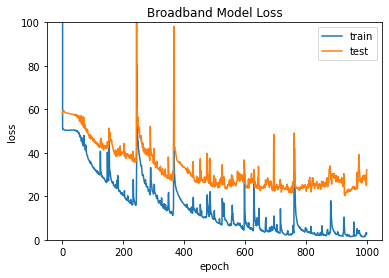

In [162]:
plot_history(
    broadband_results['loss'], 
    broadband_results['val_loss'], 
    title='Broadband Model Loss'
)

In [163]:
print(f"number of trained epochs: {np.array(broadband_results['val_loss']).argmin() + 1}")

number of trained epochs: 928


In [164]:
evalutate_model(
    HC_label_train['broadband'], 
    broadband_results['train'], 
    HC_label_test['broadband'], 
    broadband_results['test']
)

MSE_Train = 2.908
MSE_Test = 20.310
R^2score_Train = 0.940
R^2score_Test = 0.649
MSE_Train = 1.289
MAE_Test = 3.281


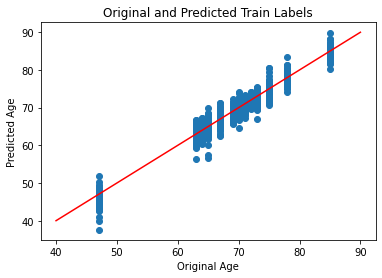

In [165]:
plot_predicted_vs_labels(
    HC_label_train['broadband'], 
    broadband_results['train'], 
    title='Train'
)

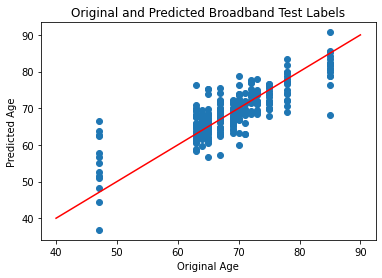

In [166]:
plot_predicted_vs_labels(
    HC_label_test['broadband'], 
    broadband_results['test'], 
    title='Broadband Test'
)
plt.savefig(f'images/{MODEL_NAME}/scatters/HC/scatter_HC_broadband.png')

#### Delta

In [167]:
delta_results = HC_results['delta']

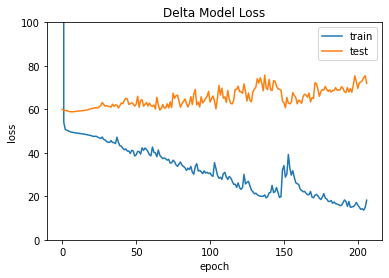

In [168]:
plot_history(
    delta_results['loss'], 
    delta_results['val_loss'], 
    title='Delta Model Loss'
)

In [169]:
print(f"number of trained epochs: {np.array(delta_results['val_loss']).argmin() + 1}")

number of trained epochs: 7


In [170]:
evalutate_model(
    HC_label_train['delta'], 
    delta_results['train'], 
    HC_label_test['delta'], 
    delta_results['test']
)

MSE_Train = 49.783
MSE_Test = 58.879
R^2score_Train = -0.020
R^2score_Test = -0.019
MSE_Train = 5.050
MAE_Test = 5.453


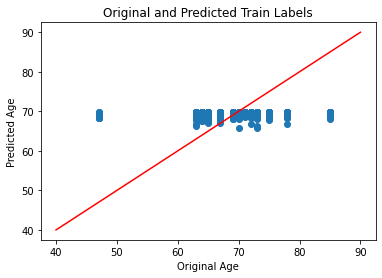

In [171]:
plot_predicted_vs_labels(
    HC_label_train['delta'], 
    delta_results['train'], 
    title='Train'
)

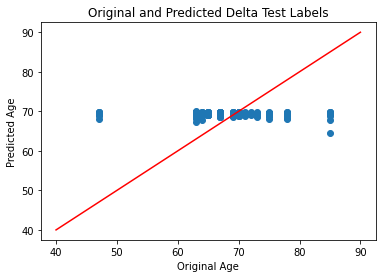

In [172]:
plot_predicted_vs_labels(
    HC_label_test['delta'],
    delta_results['test'], 
    title='Delta Test'
)
plt.savefig(f'images/{MODEL_NAME}/scatters/HC/scatter_HC_delta.png')

#### Theta

In [173]:
theta_results = HC_results['theta']

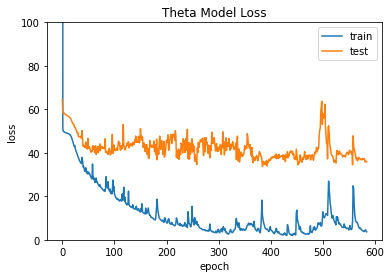

In [174]:
plot_history(
    theta_results['loss'], 
    theta_results['val_loss'], 
    title='Theta Model Loss'
)

In [175]:
print(f"number of trained epochs: {np.array(theta_results['val_loss']).argmin() + 1}")

number of trained epochs: 385


In [176]:
evalutate_model(
    HC_label_train['theta'],
    theta_results['train'], 
    HC_label_test['theta'],
    theta_results['test']
)

MSE_Train = 9.393
MSE_Test = 33.722
R^2score_Train = 0.808
R^2score_Test = 0.416
MSE_Train = 2.320
MAE_Test = 4.337


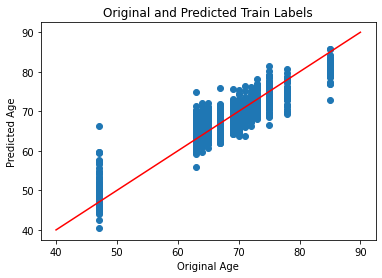

In [177]:
plot_predicted_vs_labels(
    HC_label_train['theta'],
    theta_results['train'], 
    title='Train'
)

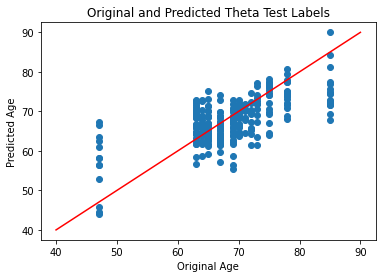

In [178]:
plot_predicted_vs_labels(
    HC_label_test['theta'], 
    theta_results['test'], 
    title='Theta Test'
)
plt.savefig(f'images/{MODEL_NAME}/scatters/HC/scatter_HC_theta.png')

#### Alpha

In [179]:
alpha_results = HC_results['alpha']

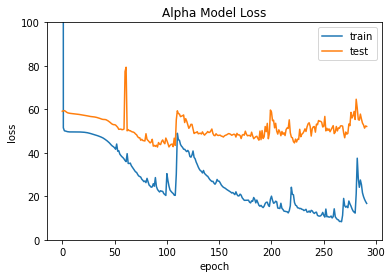

In [180]:
plot_history(
    alpha_results['loss'], 
    alpha_results['val_loss'], 
    title='Alpha Model Loss'
)

In [181]:
print(f"number of trained epochs: {np.array(alpha_results['val_loss']).argmin() + 1}")

number of trained epochs: 92


In [182]:
evalutate_model(
    HC_label_train['alpha'], 
    theta_results['train'], 
    HC_label_test['alpha'], 
    theta_results['test']
)

MSE_Train = 9.393
MSE_Test = 33.722
R^2score_Train = 0.808
R^2score_Test = 0.416
MSE_Train = 2.320
MAE_Test = 4.337


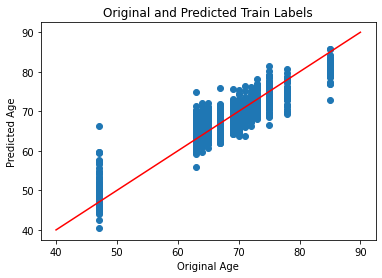

In [183]:
plot_predicted_vs_labels(
    HC_label_train['alpha'], 
    theta_results['train'], 
    title='Train'
)

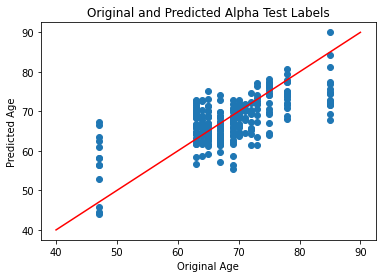

In [184]:
plot_predicted_vs_labels(
    HC_label_test['alpha'], 
    theta_results['test'], 
    title='Alpha Test'
)
plt.savefig(f'images/{MODEL_NAME}/scatters/HC/scatter_HC_alpha.png')

#### Beta

In [185]:
beta_results = HC_results['beta']

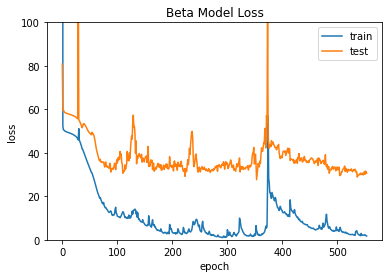

In [186]:
plot_history(
    beta_results['loss'], 
    beta_results['val_loss'], 
    title='Beta Model Loss'
)

In [187]:
print(f"number of trained epochs: {np.array(beta_results['val_loss']).argmin() + 1}")

number of trained epochs: 354


In [188]:
evalutate_model(
    HC_label_train['beta'], 
    beta_results['train'], 
    HC_label_test['beta'], 
    beta_results['test']
)

MSE_Train = 4.563
MSE_Test = 27.652
R^2score_Train = 0.907
R^2score_Test = 0.522
MSE_Train = 1.654
MAE_Test = 4.230


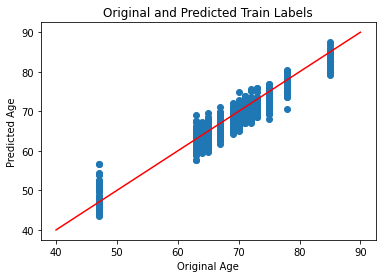

In [189]:
plot_predicted_vs_labels(
    HC_label_train['beta'], 
    beta_results['train'], 
    title='Train'
)

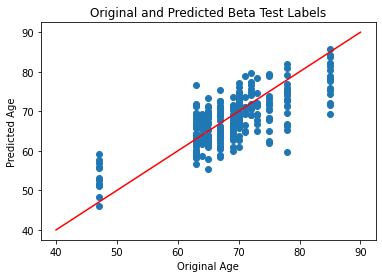

In [190]:
plot_predicted_vs_labels(
    HC_label_test['beta'], 
    beta_results['test'], 
    title='Beta Test'
)
plt.savefig(f'images/{MODEL_NAME}/scatters/HC/scatter_HC_beta.png')

#### Gamma

In [191]:
gamma_results = HC_results['gamma']

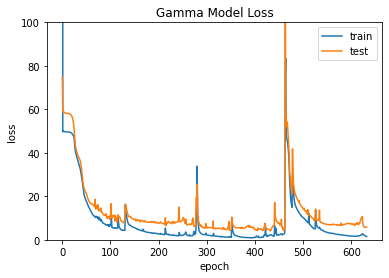

In [192]:
plot_history(
    gamma_results['loss'], 
    gamma_results['val_loss'], 
    title='Gamma Model Loss'
)

In [193]:
print(f"number of trained epochs: {np.array(gamma_results['val_loss']).argmin() + 1}")

number of trained epochs: 433


In [194]:
evalutate_model(
    HC_label_train['gamma'], 
    gamma_results['train'], 
    HC_label_test['gamma'], 
    gamma_results['test']
)

MSE_Train = 1.201
MSE_Test = 4.031
R^2score_Train = 0.975
R^2score_Test = 0.930
MSE_Train = 0.859
MAE_Test = 1.496


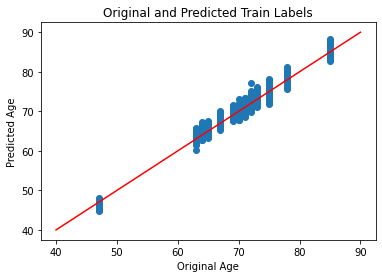

In [195]:
plot_predicted_vs_labels(
    HC_label_train['gamma'], 
    gamma_results['train'], 
    title='Train'
)

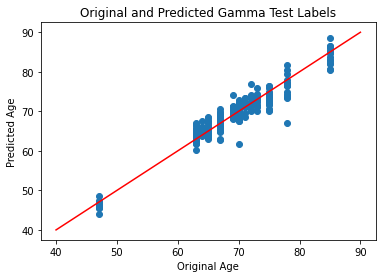

In [196]:
plot_predicted_vs_labels(
    HC_label_test['gamma'], 
    gamma_results['test'], 
    title='Gamma Test'
)
plt.savefig(f'images/{MODEL_NAME}/scatters/HC/scatter_HC_gamma.png')

### Models for PD

In [197]:
PD_med = dict()
for key in PD: 
    PD_med[key] = np.zeros((PD[key].shape[0], PD[key].shape[1], PD[key].shape[2] + 1))
    PD_med[key][:, :, :PD[key].shape[2]] = PD[key]
    for i in range(len(PD_med[key])):
        PD_med[key][i, :, -1] = PD_labels['taken_med'][i]

In [198]:
PD_train = {}; PD_test = {}; PD_label_train = {}; PD_label_test = {};
for key in PD_med:
    X_train, X_test, y_train, y_test = train_test_split(PD_med[key], PD_labels['age'], test_size=0.2, random_state=SEED)
    PD_train[key] = X_train
    PD_test[key] = X_test
    PD_label_train[key] = y_train
    PD_label_test[key] = y_test

In [199]:
try:
    with open(f'results/{MODEL_NAME}/PD_results.pickle', 'rb') as f:
        PD_results = pickle.load(f)
except Exception:
    PD_results = run_model(MODEL_FUNC, MODEL_NAME, 'PD', PD_train, PD_test, PD_label_train, PD_label_test)

In [200]:
with open(f'results/{MODEL_NAME}/PD_results.pickle', 'wb+') as f:
    pickle.dump(PD_results, f)

#### BroadBand

In [201]:
broadband_results = PD_results['broadband']

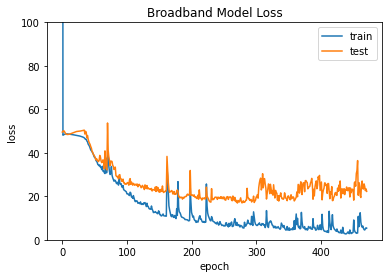

In [202]:
plot_history(
    broadband_results['loss'], 
    broadband_results['val_loss'], 
    title='Broadband Model Loss'
)

In [203]:
print(f"number of trained epochs: {np.array(broadband_results['val_loss']).argmin() + 1}")

number of trained epochs: 272


In [204]:
evalutate_model(
    PD_label_train['broadband'], 
    broadband_results['train'], 
    PD_label_test['broadband'], 
    broadband_results['test']
)

MSE_Train = 5.924
MSE_Test = 16.920
R^2score_Train = 0.874
R^2score_Test = 0.649
MSE_Train = 1.913
MAE_Test = 3.206


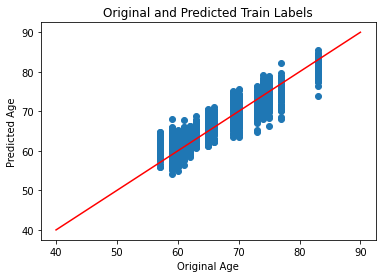

In [205]:
plot_predicted_vs_labels(
    PD_label_train['broadband'], 
    broadband_results['train'], 
    title='Train'
)

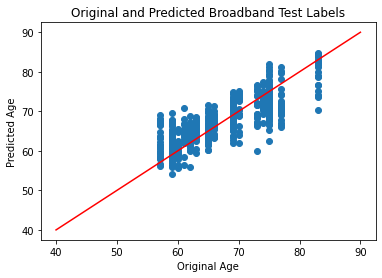

In [206]:
plot_predicted_vs_labels(
    PD_label_test['broadband'], 
    broadband_results['test'], 
    title='Broadband Test'
)
plt.savefig(f'images/{MODEL_NAME}/scatters/PD/scatter_PD_broadband.png')

#### Delta

In [207]:
delta_results = PD_results['delta']

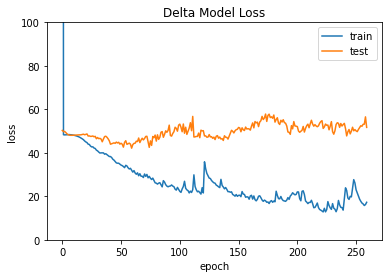

In [208]:
plot_history(
    delta_results['loss'], 
    delta_results['val_loss'], 
    title='Delta Model Loss'
)

In [209]:
print(f"number of trained epochs: {np.array(delta_results['val_loss']).argmin() + 1}")

number of trained epochs: 60


In [210]:
evalutate_model(
    PD_label_train['delta'], 
    delta_results['train'], 
    PD_label_test['delta'], 
    delta_results['test']
)

MSE_Train = 30.219
MSE_Test = 42.147
R^2score_Train = 0.359
R^2score_Test = 0.125
MSE_Train = 4.462
MAE_Test = 5.310


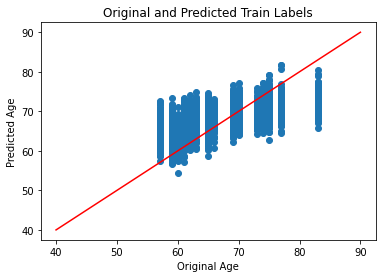

In [211]:
plot_predicted_vs_labels(
    PD_label_train['delta'], 
    delta_results['train'], 
    title='Train'
)

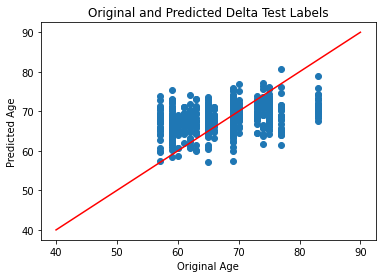

In [212]:
plot_predicted_vs_labels(
    PD_label_test['delta'], 
    delta_results['test'], 
    title='Delta Test'
)
plt.savefig(f'images/{MODEL_NAME}/scatters/PD/scatter_PD_delta.png')

#### Theta

In [213]:
theta_results = PD_results['theta']

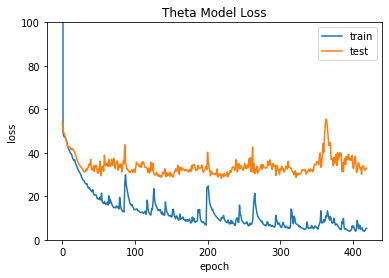

In [214]:
plot_history(
    theta_results['loss'], 
    theta_results['val_loss'], 
    title='Theta Model Loss'
)

In [215]:
print(f"number of trained epochs: {np.array(theta_results['val_loss']).argmin() + 1}")

number of trained epochs: 220


In [216]:
evalutate_model(
    PD_label_train['theta'], 
    theta_results['train'], 
    PD_label_test['theta'], 
    theta_results['test']
)

MSE_Train = 10.202
MSE_Test = 28.284
R^2score_Train = 0.784
R^2score_Test = 0.413
MSE_Train = 2.498
MAE_Test = 4.140


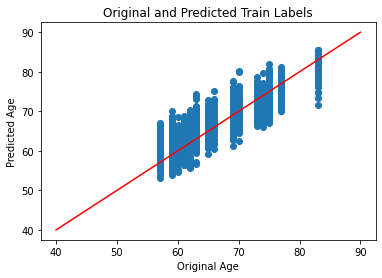

In [217]:
plot_predicted_vs_labels(
    PD_label_train['theta'], 
    theta_results['train'], 
    title='Train'
)

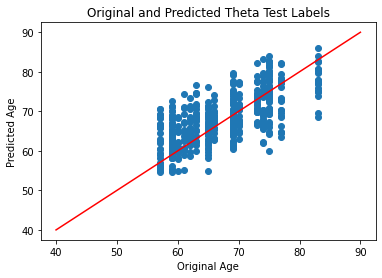

In [218]:
plot_predicted_vs_labels(
    PD_label_test['theta'], 
    theta_results['test'], 
    title='Theta Test'
)
plt.savefig(f'images/{MODEL_NAME}/scatters/PD/scatter_PD_theta.png')

#### Alpha

In [219]:
alpha_results = PD_results['alpha']

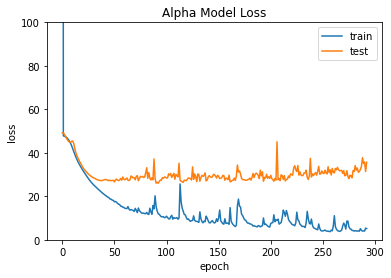

In [220]:
plot_history(
    alpha_results['loss'], 
    alpha_results['val_loss'], 
    title='Alpha Model Loss'
)

In [221]:
print(f"number of trained epochs: {np.array(alpha_results['val_loss']).argmin() + 1}")

number of trained epochs: 93


In [222]:
evalutate_model(
    PD_label_train['alpha'], 
    alpha_results['train'], 
    PD_label_test['alpha'], 
    alpha_results['test']
)

MSE_Train = 11.142
MSE_Test = 26.005
R^2score_Train = 0.764
R^2score_Test = 0.460
MSE_Train = 2.633
MAE_Test = 4.013


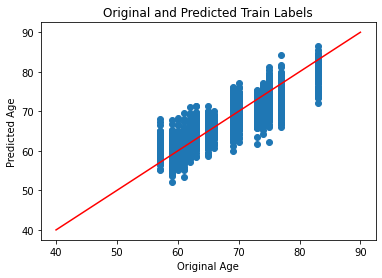

In [223]:
plot_predicted_vs_labels(
    PD_label_train['alpha'], 
    alpha_results['train'], 
    title='Train'
)

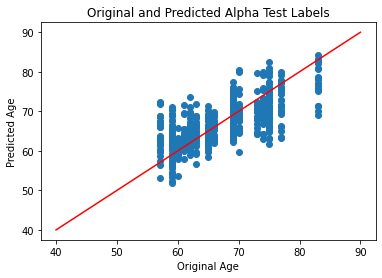

In [224]:
plot_predicted_vs_labels(
    PD_label_test['alpha'], 
    alpha_results['test'],
    title='Alpha Test'
)
plt.savefig(f'images/{MODEL_NAME}/scatters/PD/scatter_PD_alpha.png')

#### Beta

In [225]:
beta_results = PD_results['beta']

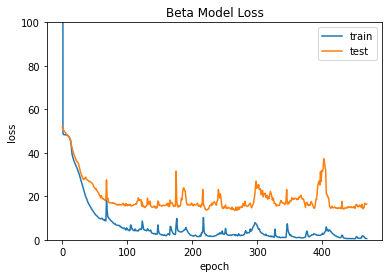

In [226]:
plot_history(
    beta_results['loss'], 
    beta_results['val_loss'], 
    title='Beta Model Loss'
)

In [227]:
print(f"number of trained epochs: {np.array(beta_results['val_loss']).argmin() + 1}")

number of trained epochs: 269


In [228]:
evalutate_model(
    PD_label_train['beta'], 
    beta_results['train'], 
    PD_label_test['beta'], 
    beta_results['test']
)

MSE_Train = 1.810
MSE_Test = 13.579
R^2score_Train = 0.962
R^2score_Test = 0.718
MSE_Train = 1.059
MAE_Test = 2.824


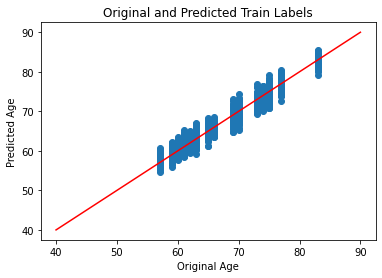

In [229]:
plot_predicted_vs_labels(
    PD_label_train['beta'], 
    beta_results['train'], 
    title='Train'
)

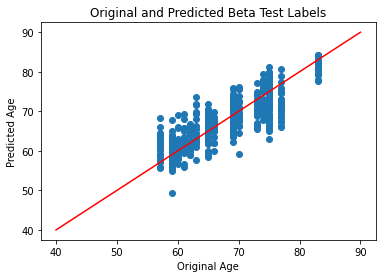

In [230]:
plot_predicted_vs_labels(
    PD_label_test['beta'], 
    beta_results['test'],
    title='Beta Test'
)
plt.savefig(f'images/{MODEL_NAME}/scatters/PD/scatter_PD_beta.png')

#### Gamma

In [231]:
gamma_results = PD_results['gamma']

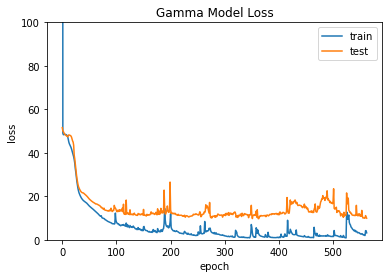

In [232]:
plot_history(
    gamma_results['loss'], 
    gamma_results['val_loss'], 
    title='Gamma Model Loss'
)

In [233]:
print(f"number of trained epochs: {np.array(gamma_results['val_loss']).argmin() + 1}")

number of trained epochs: 363


In [234]:
evalutate_model(
    PD_label_train['gamma'], 
    gamma_results['train'], 
    PD_label_test['gamma'], 
    gamma_results['test']
)

MSE_Train = 2.551
MSE_Test = 9.708
R^2score_Train = 0.946
R^2score_Test = 0.798
MSE_Train = 1.234
MAE_Test = 2.314


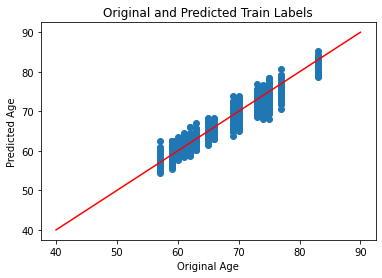

In [235]:
plot_predicted_vs_labels(
    PD_label_train['gamma'], 
    gamma_results['train'], 
    title='Train'
)

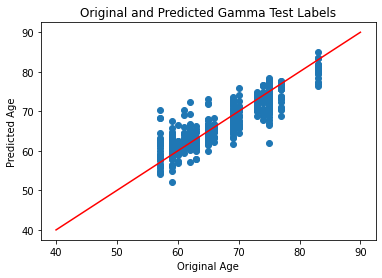

In [236]:
plot_predicted_vs_labels(
    PD_label_test['gamma'], 
    gamma_results['test'],
    title='Gamma Test'
)
plt.savefig(f'images/{MODEL_NAME}/scatters/PD/scatter_PD_gamma.png')

## Analysis

### Bar Chart

#### HC

In [237]:
HC_means = dict()
HC_stds = dict()
for key in HC_results:
    diff = HC_results[key]['test'] - HC_label_test[key]
    diff = np.abs(diff)
    HC_means[key] = np.mean(diff)
    HC_stds[key] = np.std(diff) / np.sqrt(len(diff))

In [238]:
HC_mean = np.mean(HC_label_train['alpha'])
HC_mean = np.ones_like(HC_label_train['alpha']) * HC_mean
HC_baseline = mean_absolute_error(HC_label_train['alpha'], HC_mean)
HC_baseline

5.0083237

#### PD

In [239]:
PD_means = dict()
PD_stds = dict()
for key in PD_results:
    diff = PD_results[key]['test'] - PD_label_test[key]
    diff = np.abs(diff)
    PD_means[key] = np.mean(diff)
    PD_stds[key] = np.std(diff) / np.sqrt(len(diff))

In [240]:
PD_mean = np.mean(PD_label_train['alpha'])
PD_mean = np.ones_like(PD_label_train['alpha']) * PD_mean
PD_baseline = mean_absolute_error(PD_label_train['alpha'], PD_mean)
PD_baseline

5.824054

#### Plot

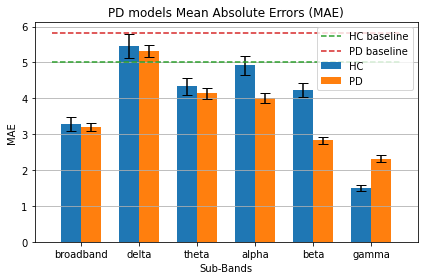

In [241]:
model_errors_barchart(
    names, 
    [HC_means[key] for key in names],
    [PD_means[key] for key in names],
    [HC_stds[key] for key in names],
    [PD_stds[key] for key in names],
    HC_baseline, PD_baseline,
    'PD models Mean Absolute Errors (MAE)',
)

plt.savefig(f'images/{MODEL_NAME}/HC_PD_barchart.png')

### Saliency Map

In [242]:
import seaborn as sns

In [287]:
def saliency_map(model, data, output):
    with tf.GradientTape() as tape:
        tape.watch(data)
        predictions = model(data)
        loss = tf.metrics.mse(predictions, output)

    # Get the gradients of the loss w.r.t to the input image.
    gradient = tape.gradient(loss, data)
    g_abs = tf.math.abs(gradient).numpy()
    g_min, g_max = g_abs.min(), g_abs.max()
    g_norm = (g_abs - g_min) / (g_max - g_min + np.finfo(float).eps)
    g_norm = g_norm.reshape((g_norm.shape[1:3]))
    return g_norm

In [288]:
def get_saliency(model, inp, out):
    inp = inp.reshape([1, *inp.shape])
    inp = tf.convert_to_tensor(inp)
    out = tf.convert_to_tensor(out)
    return saliency_map(model, inp, out) 

#### HC

##### Min

In [243]:
min_index = HC_label_test['broadband'].argmin()
max_index = HC_label_test['broadband'].argmax()

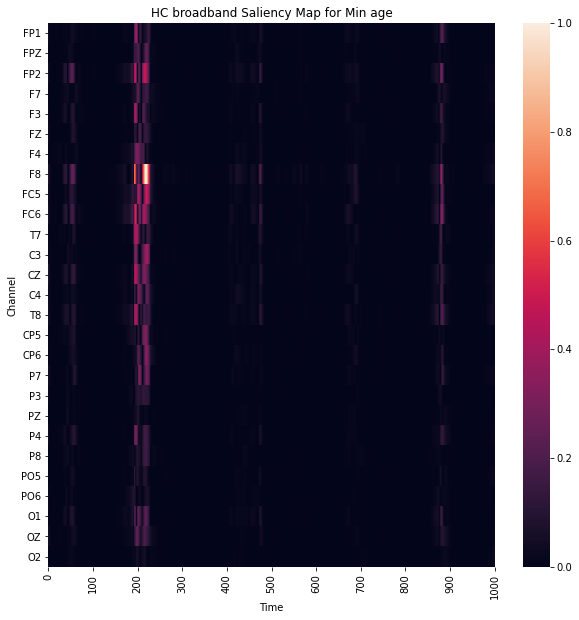

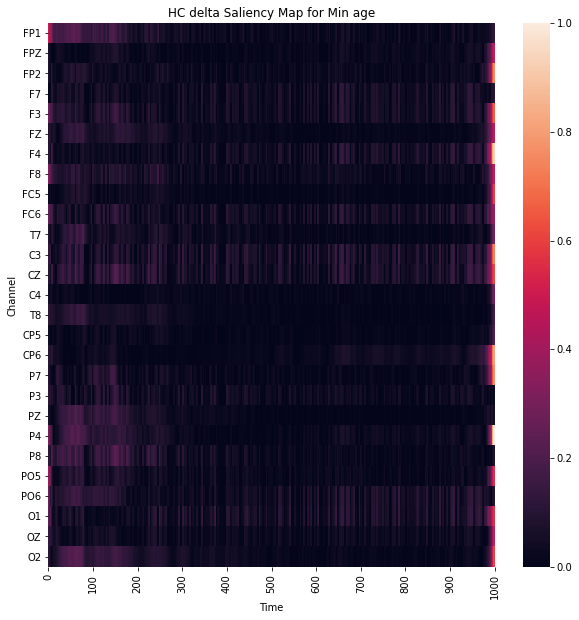

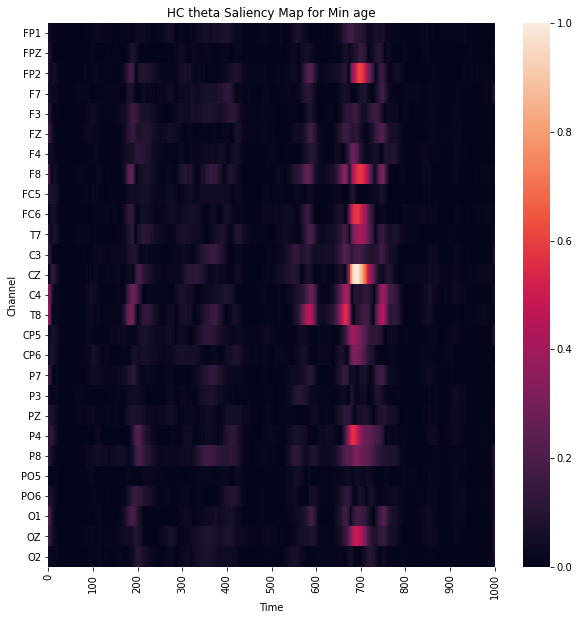

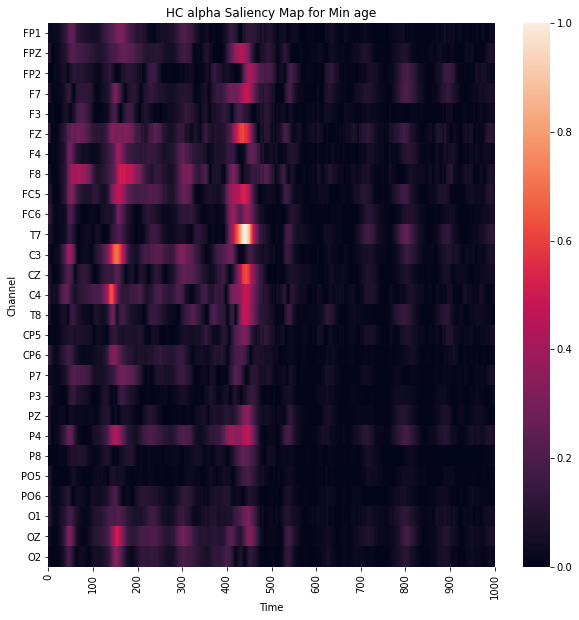

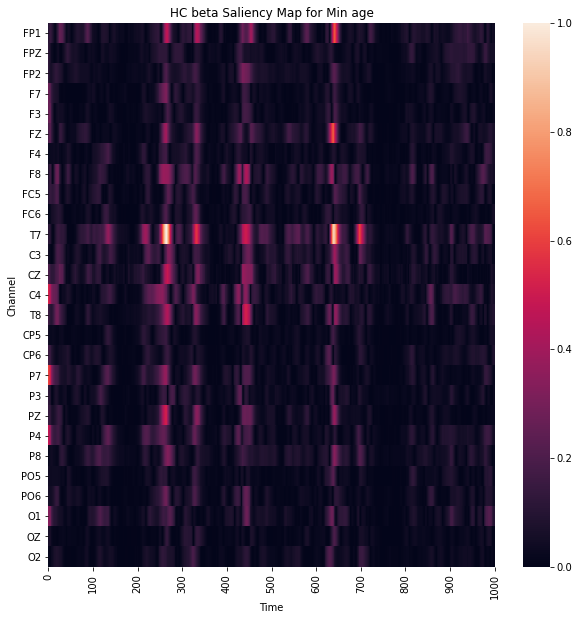

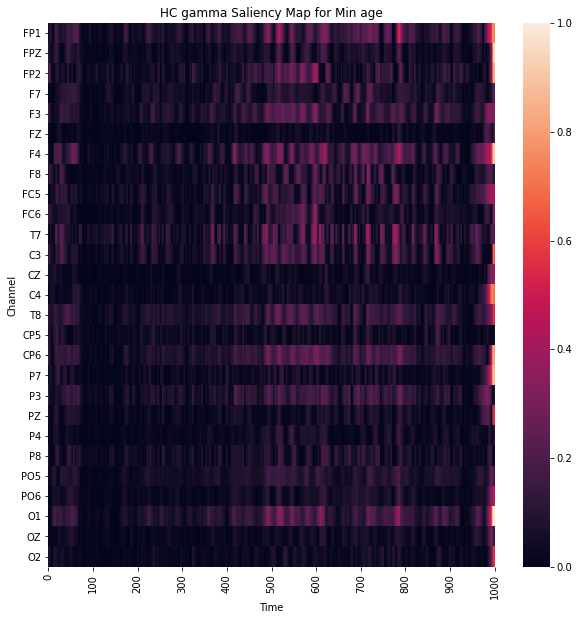

In [244]:
for name in names: 
    model = load_model(f'models/{MODEL_NAME}/HC/{name}.h5')
    saliency = get_saliency(
        model, HC_test[name][min_index], HC_label_test[name][min_index].astype('float32')
    )
    saliency_heat_map(saliency, f'HC {name} Saliency Map for Min age')
    plt.savefig(f'images/{MODEL_NAME}/saliencies/hc/min/HC_{name}_min_saliency.png')

##### Max

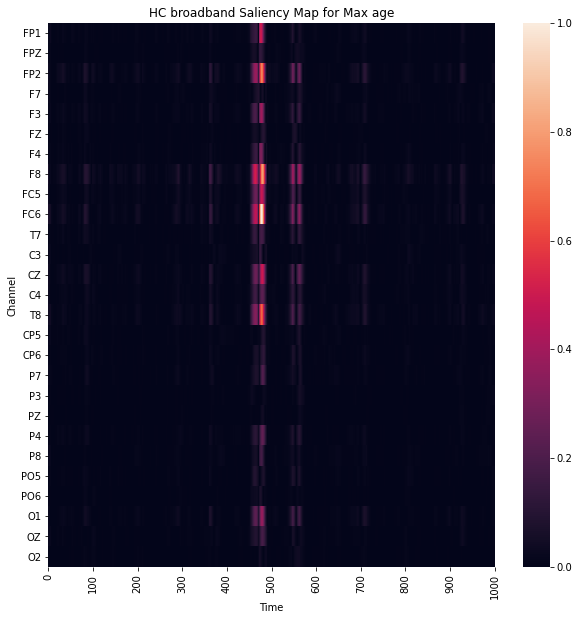

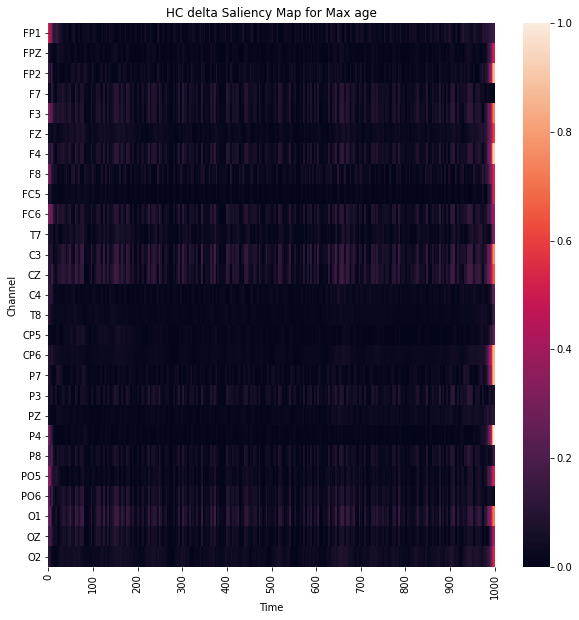

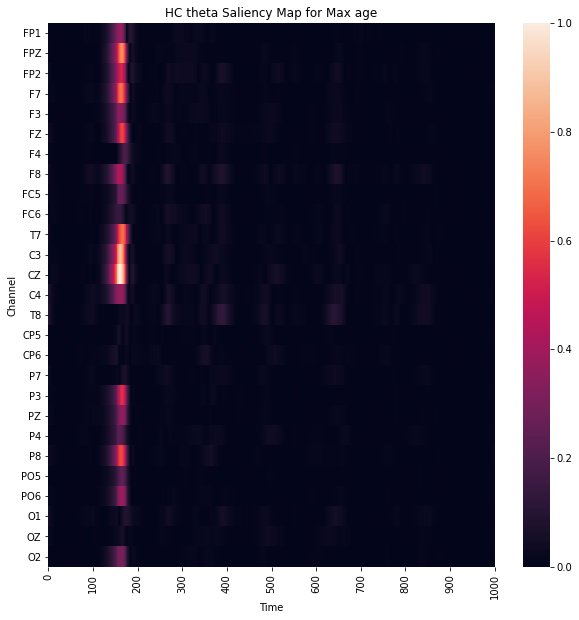

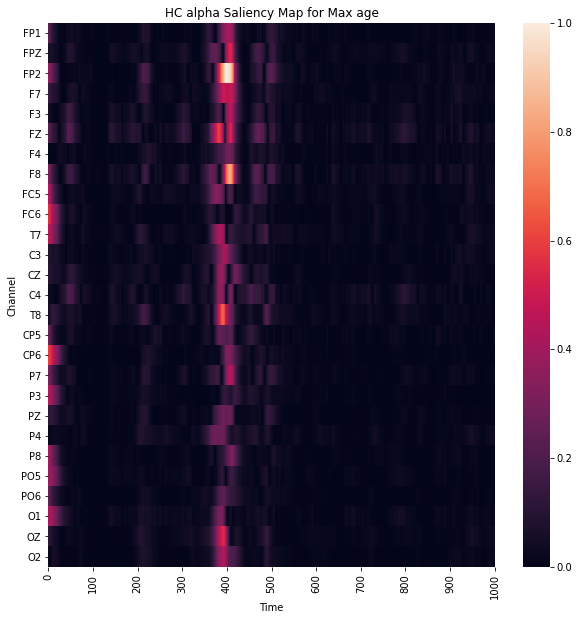

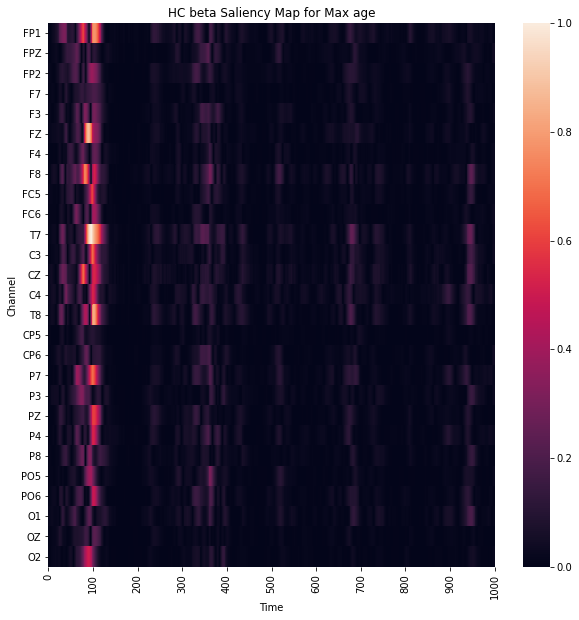

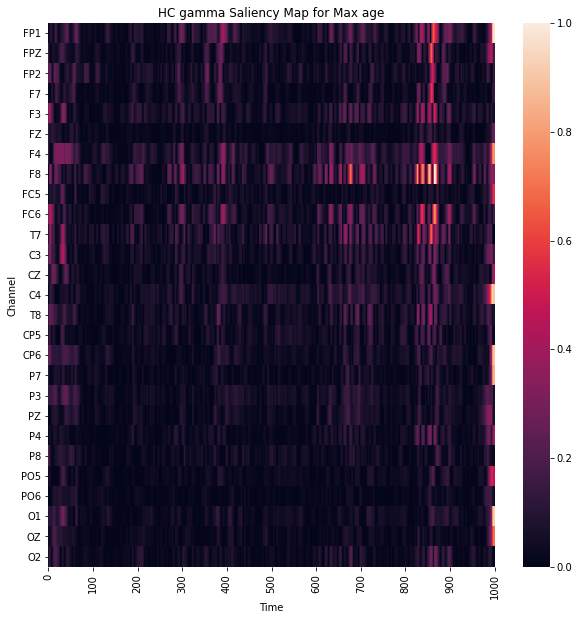

In [245]:
for name in names: 
    model = load_model(f'models/{MODEL_NAME}/HC/{name}.h5')
    saliency = get_saliency(
        model, HC_test[name][max_index], HC_label_test[name][max_index].astype('float32')
    )
    saliency_heat_map(saliency, f'HC {name} Saliency Map for Max age')
    plt.savefig(f'images/{MODEL_NAME}/saliencies/hc/max/HC_{name}_max_saliency.png')

#### PD

##### Min

In [246]:
min_val = PD_label_test['broadband'].min()
max_val = PD_label_test['broadband'].max()

In [247]:
min_indexes = PD_label_test['broadband'] == min_val
min_indexes = min_indexes[:, 0]

In [248]:
taken_med = PD_test['broadband'][:, :, 27].sum(axis=1) > 0

In [249]:
min_index_on = np.logical_and(taken_med, min_indexes).argmax()
min_index_off = np.logical_and(~taken_med, min_indexes).argmax()

(500, 28)
(500, 28)
(500, 28)
(500, 28)
(500, 28)
(500, 28)


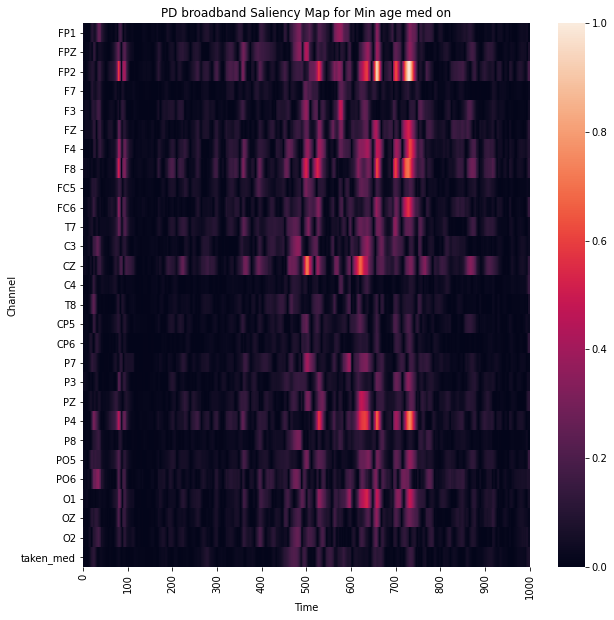

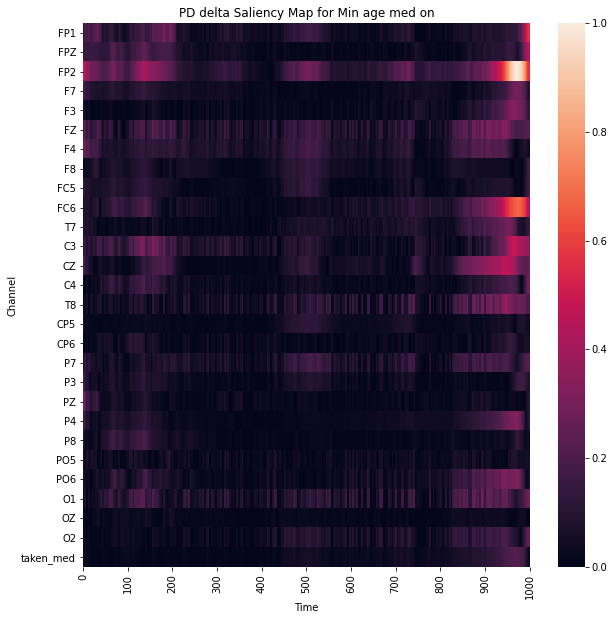

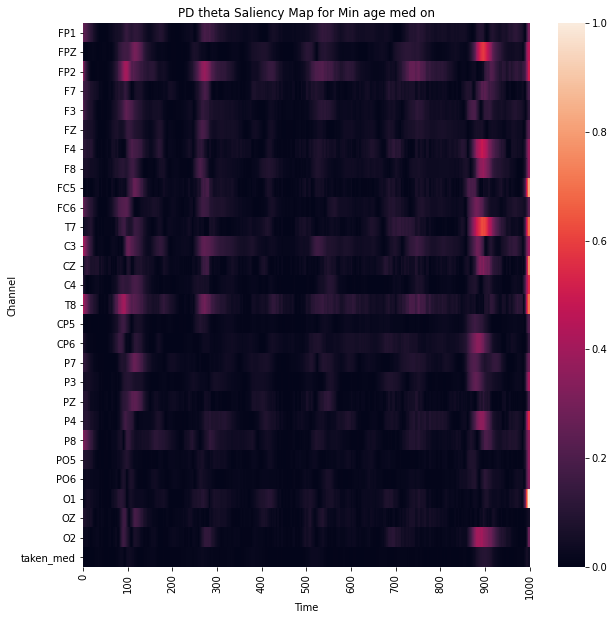

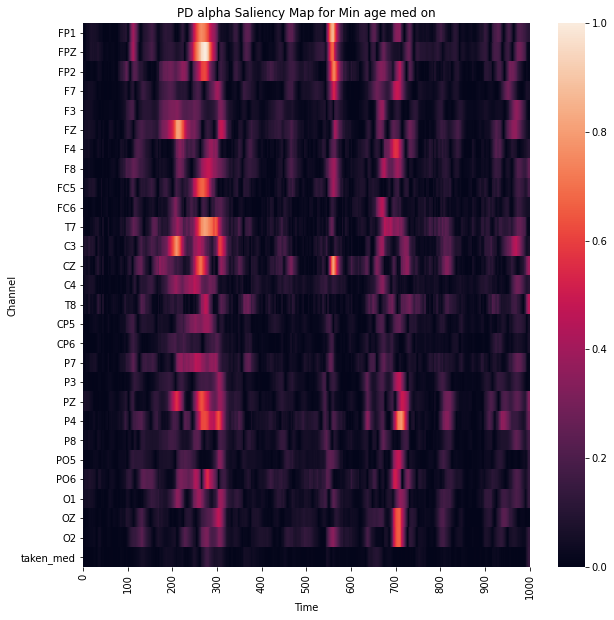

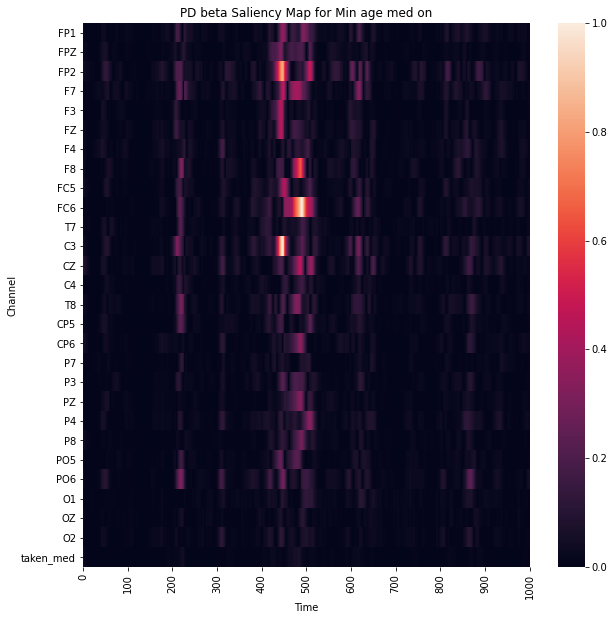

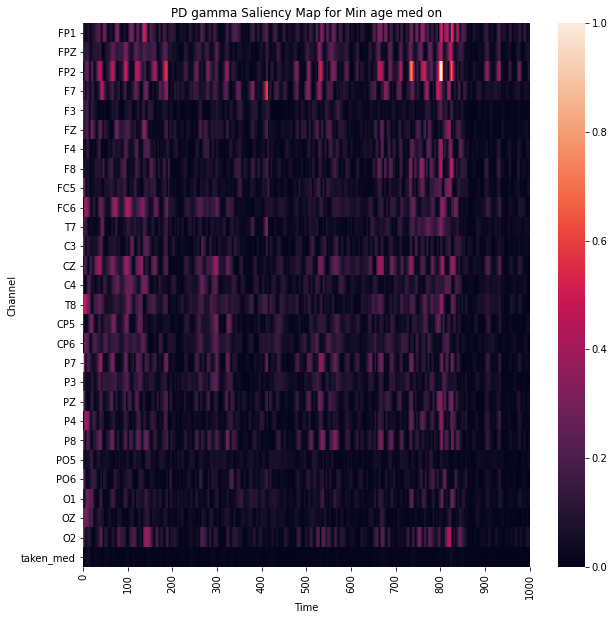

In [250]:
for name in names: 
    model = load_model(f'models/{MODEL_NAME}/PD/{name}.h5')
    saliency = get_saliency(
        model, PD_test[name][min_index_on], PD_label_test[name][min_index_on].astype('float32')
    )
    saliency_heat_map_PD(saliency, f'PD {name} Saliency Map for Min age med on')
    plt.savefig(f'images/{MODEL_NAME}/saliencies/pd_on/min/PD_{name}_min_on_saliency.png')

(500, 28)
(500, 28)
(500, 28)
(500, 28)
(500, 28)
(500, 28)


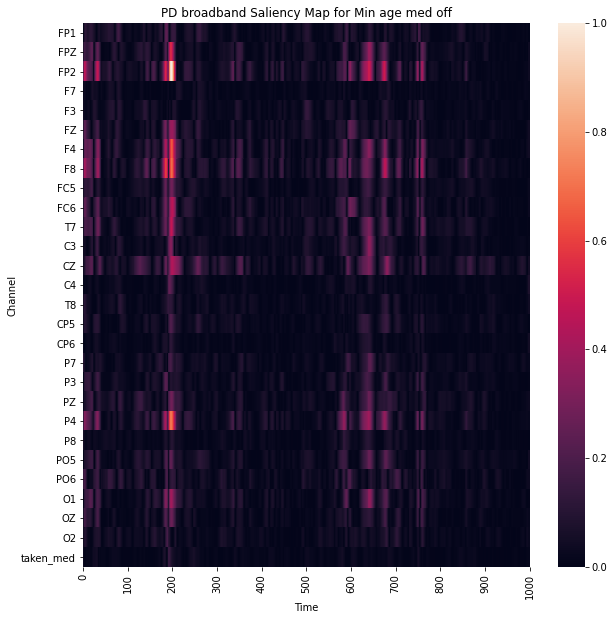

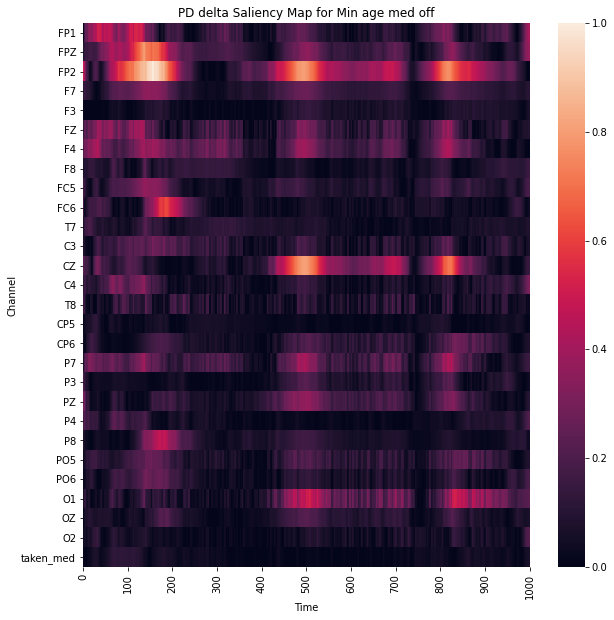

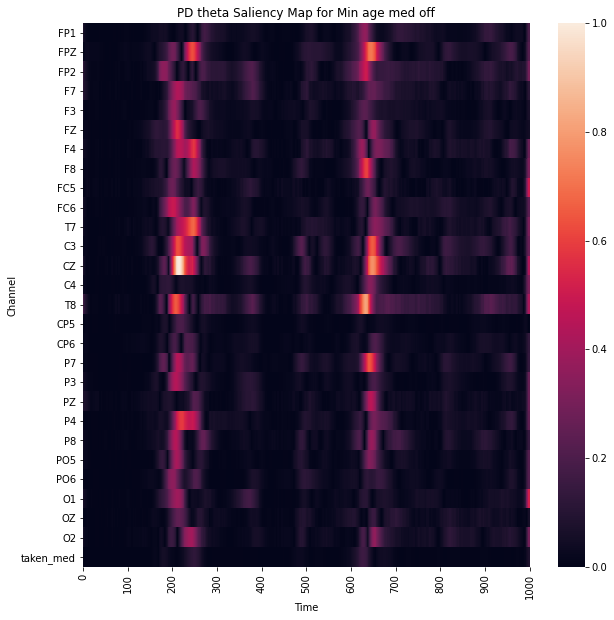

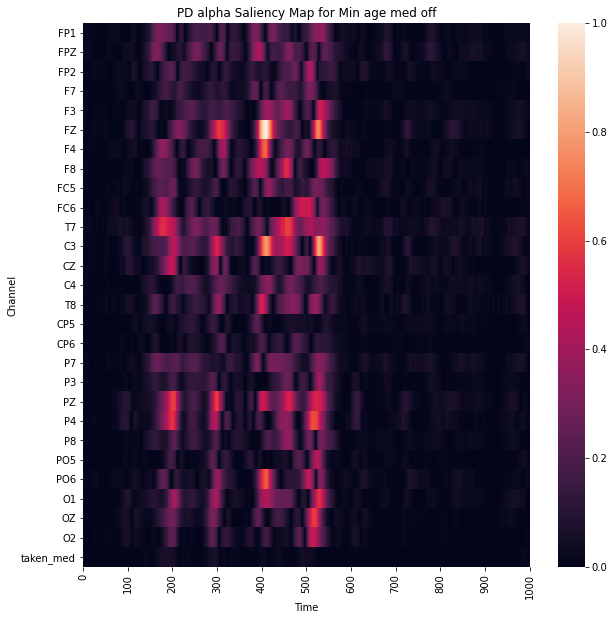

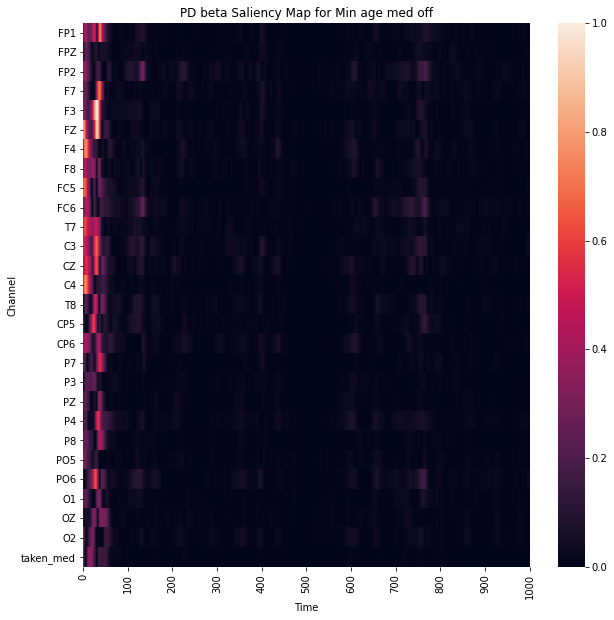

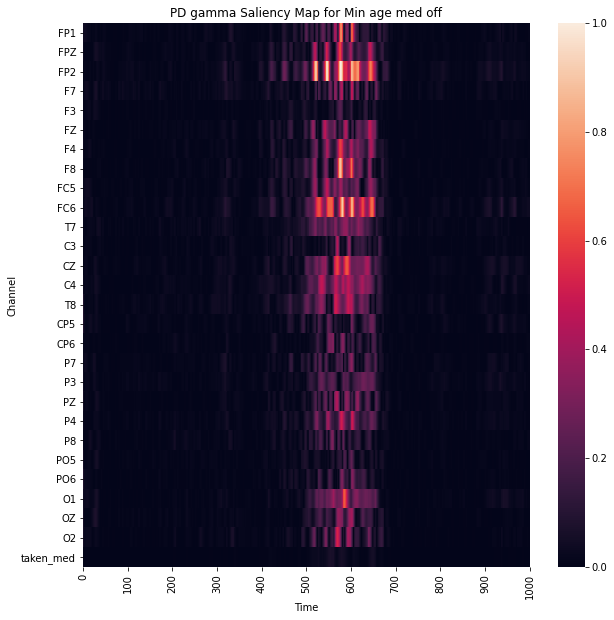

In [251]:
for name in names: 
    model = load_model(f'models/{MODEL_NAME}/PD/{name}.h5')
    saliency = get_saliency(
        model, PD_test[name][min_index_off], PD_label_test[name][min_index_off].astype('float32')
    )
    saliency_heat_map_PD(saliency, f'PD {name} Saliency Map for Min age med off')
    plt.savefig(f'images/{MODEL_NAME}/saliencies/pd_off/min/PD_{name}_min_off_saliency.png')

##### Max

In [252]:
max_indexes = PD_label_test['broadband'] == max_val
max_indexes = max_indexes[:, 0]

In [253]:
max_index_on = np.logical_and(taken_med, max_indexes).argmax()
max_index_off = np.logical_and(~taken_med, max_indexes).argmax()

(500, 28)
(500, 28)
(500, 28)
(500, 28)
(500, 28)
(500, 28)


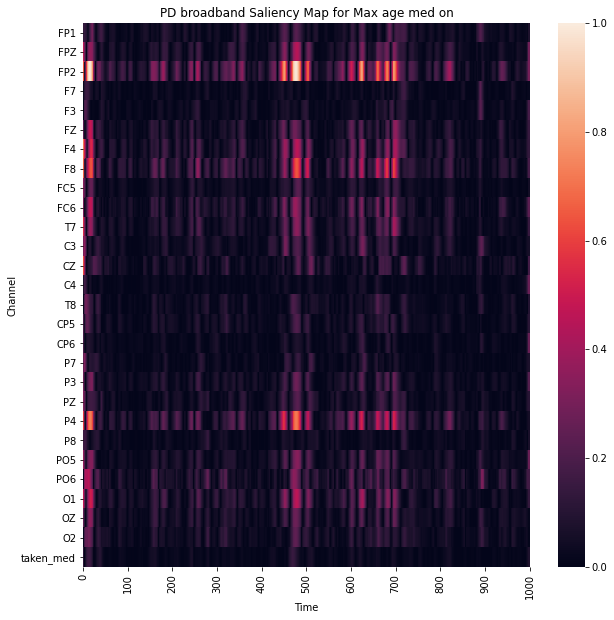

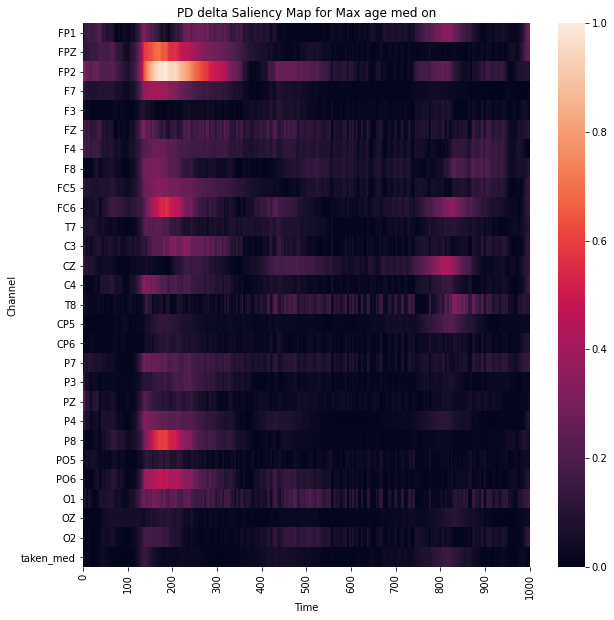

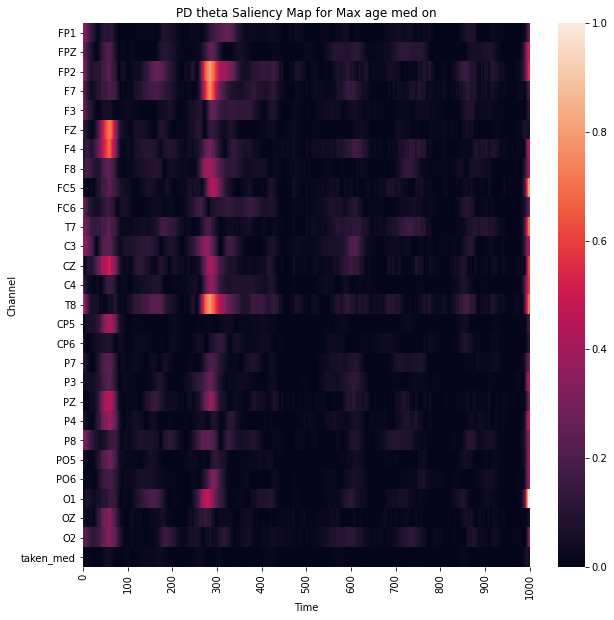

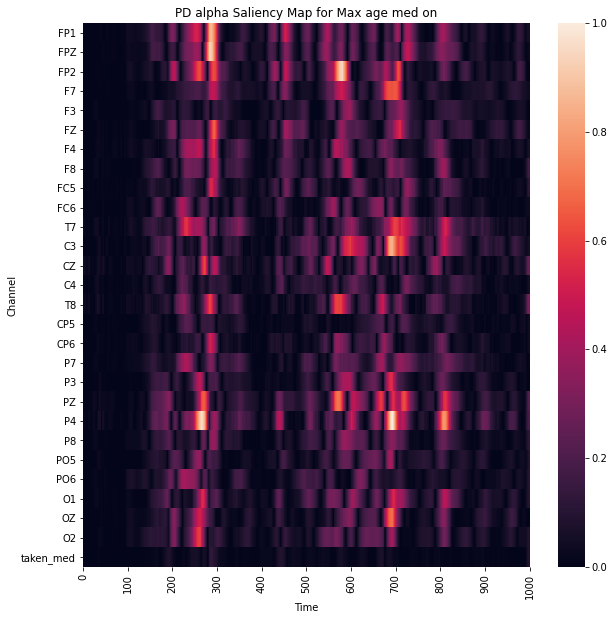

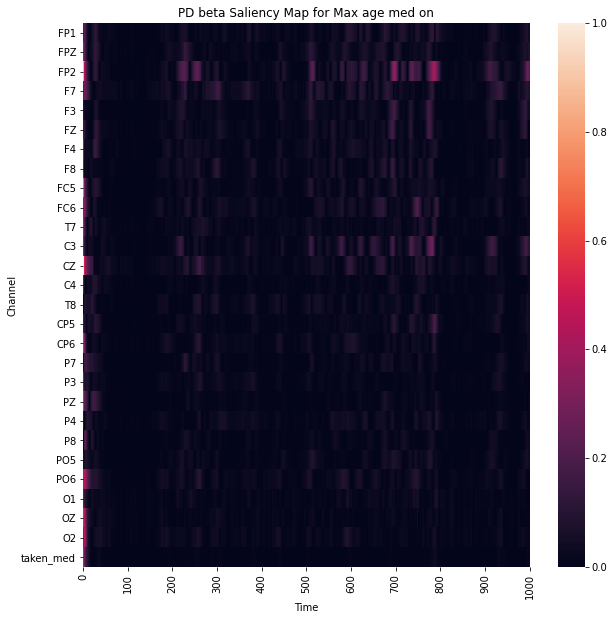

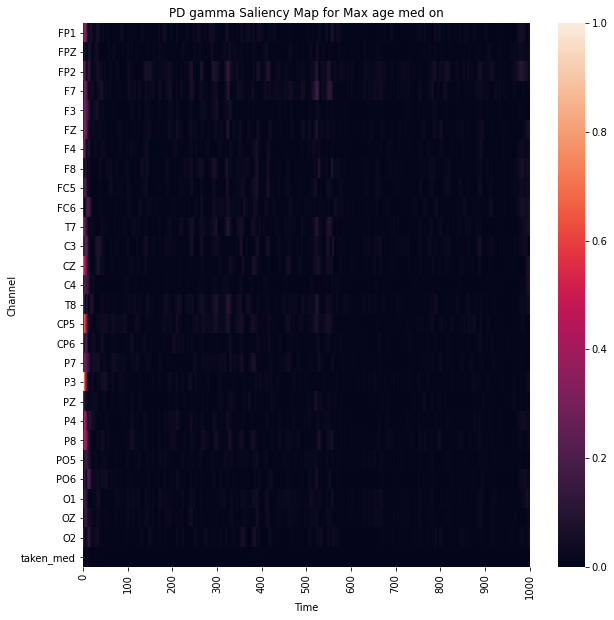

In [254]:
for name in names: 
    model = load_model(f'models/{MODEL_NAME}/PD/{name}.h5')
    saliency = get_saliency(
        model, PD_test[name][max_index_on], PD_label_test[name][max_index_on].astype('float32')
    )
    saliency_heat_map_PD(saliency, f'PD {name} Saliency Map for Max age med on')
    plt.savefig(f'images/{MODEL_NAME}/saliencies/pd_on/max/PD_{name}_max_on_saliency.png')

(500, 28)
(500, 28)
(500, 28)
(500, 28)
(500, 28)
(500, 28)


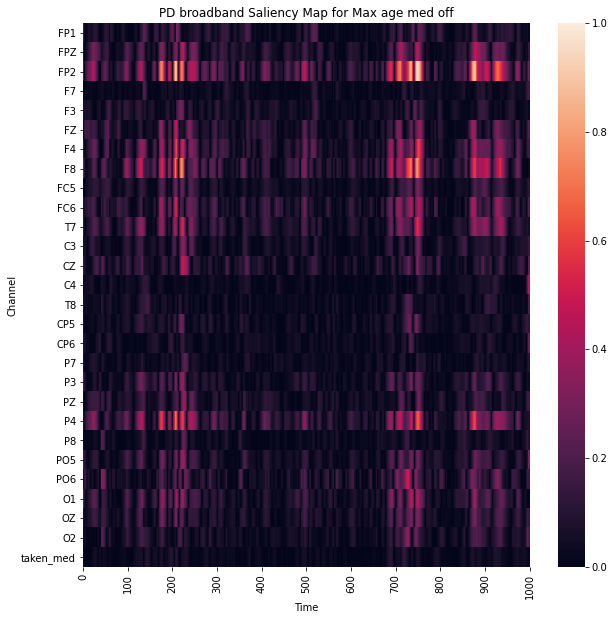

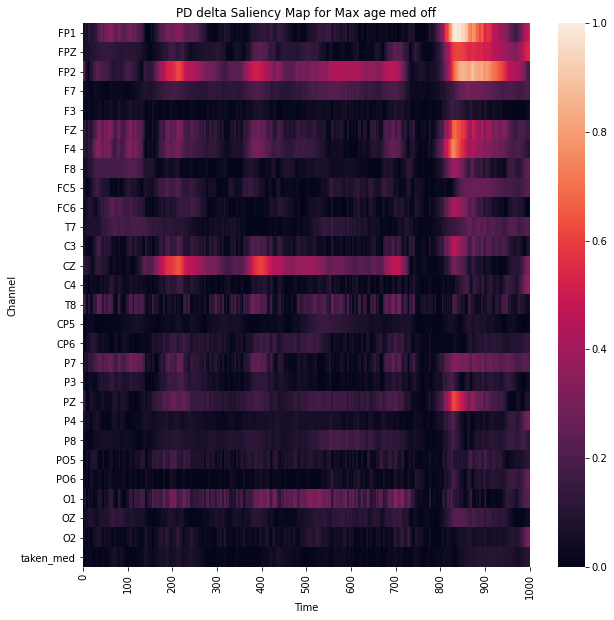

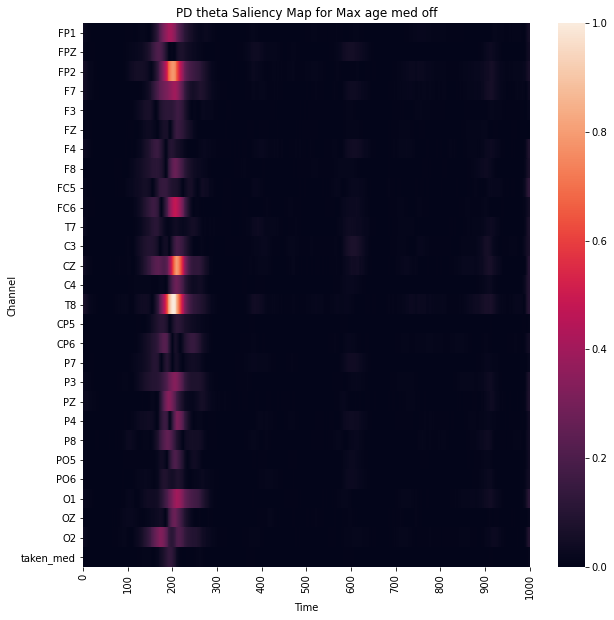

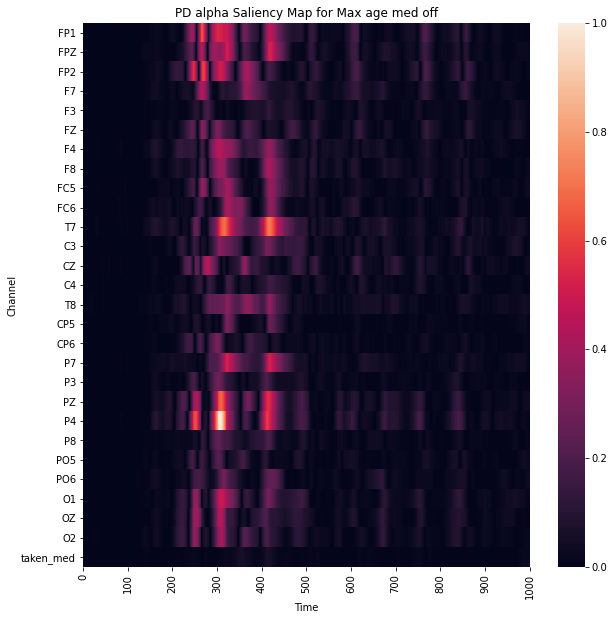

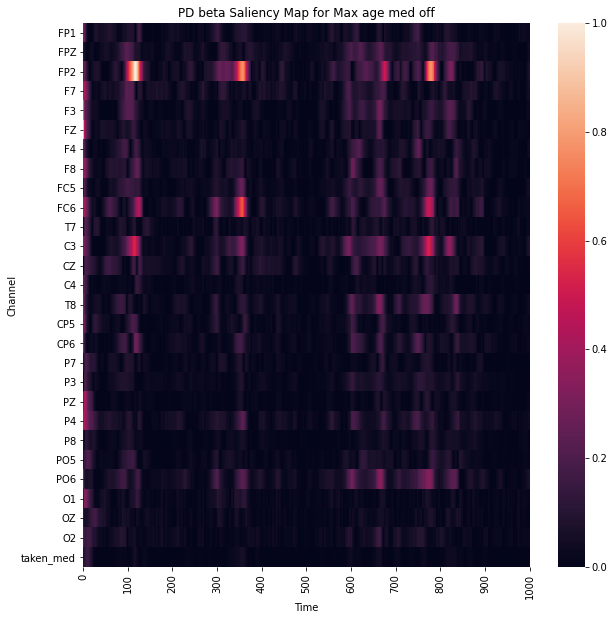

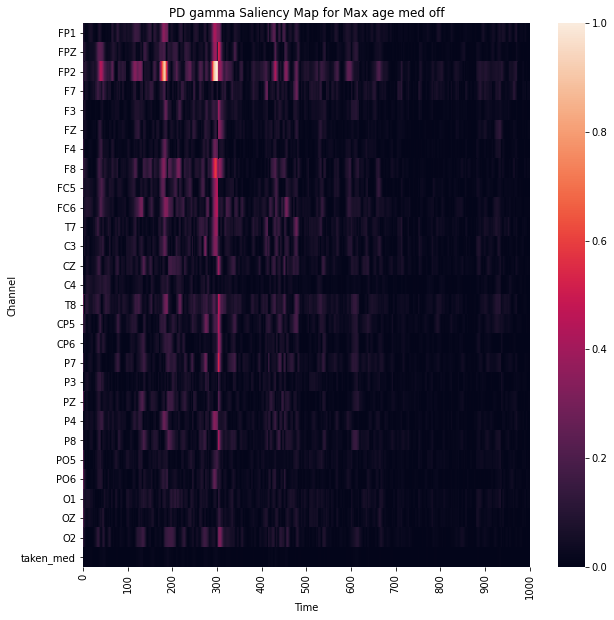

In [255]:
for name in names: 
    model = load_model(f'models/{MODEL_NAME}/PD/{name}.h5')
    saliency = get_saliency(
        model, PD_test[name][max_index_off], PD_label_test[name][max_index_off].astype('float32')
    )
    saliency_heat_map_PD(saliency, f'PD {name} Saliency Map for Max age med off')
    plt.savefig(f'images/{MODEL_NAME}/saliencies/pd_off/max/PD_{name}_max_off_saliency.png')

### Test Sensors' Errors

#### Functions

In [260]:
from sklearn.preprocessing import MinMaxScaler
import matplotlib.image as mpimg

In [261]:
def test_sensor_error(model, x_test, y_test):
    results = list()
    for i in range(x_test.shape[2]):
        inp = np.copy(x_test)
        inp[:, :, i] = 0
        loss, accuracy = model.evaluate(inp, y_test)
        results.append(loss)
    return np.array(results)

In [262]:
def get_errors_on_multiple_models(model_name, folder_name, x_test, y_test):
    results = dict()
    for key in x_test:
        model = load_model(f'models/{model_name}/{folder_name}/{key}.h5')
        results[key] = test_sensor_error(model, x_test[key], y_test[key])
    return results

#### HC

In [263]:
HC_models_sensor_errors = get_errors_on_multiple_models(MODEL_NAME, 'HC', HC_test, HC_label_test)

9/9 [==============================] - 0s 11ms/step - loss: 26.5036 - mean_squared_error: 26.5036


In [264]:
HC_models_sensor_errors['gamma'].min()

3.664917469024658

In [265]:
HC_models_sensor_errors_norm = dict()
for key in HC_models_sensor_errors: 
    normalizer = MinMaxScaler()
    HC_models_sensor_errors_norm[key] = normalizer.fit_transform(
        HC_models_sensor_errors[key].reshape(-1, 1)
    )

In [266]:
sio.savemat(f'results/{MODEL_NAME}/HC_models_sensor_errors.mat', HC_models_sensor_errors_norm)

For making Headplots of these errors, I used topoplot function in matlab [EEGlab](https://www.mathworks.com/matlabcentral/fileexchange/56415-eeglab) add-on.  
Here is the result.

In [267]:
# img = mpimg.imread(f'images/{MODEL_NAME}/HC_models_sensor_errors.png')
# plt.figure(figsize=(10, 10))
# plt.imshow(img)
# plt.axis('off')

#### PD

In [268]:
PD_models_sensor_errors = get_errors_on_multiple_models(MODEL_NAME, 'PD', PD_test, PD_label_test)

15/15 [==============================] - 0s 11ms/step - loss: 37.9567 - mean_squared_error: 37.9567


15/15 [==============================] - 0s 11ms/step - loss: 20.6562 - mean_squared_error: 20.6562


In [269]:
PD_models_sensor_errors['gamma'].max()

43.29313659667969

In [270]:
PD_models_sensor_errors_norm = dict()
for key in PD_models_sensor_errors: 
    normalizer = MinMaxScaler()
    PD_models_sensor_errors_norm[key] = normalizer.fit_transform(
        PD_models_sensor_errors[key].reshape(-1, 1)
    )

In [271]:
sio.savemat(f'results/{MODEL_NAME}/PD_models_sensor_errors.mat', PD_models_sensor_errors_norm)

In [272]:
# img = mpimg.imread(f'images/{MODEL_NAME}/PD_models_sensor_errors.png')
# plt.figure(figsize=(10, 10))
# plt.imshow(img)
# plt.axis('off')

In [273]:
((HC_test['theta'] == HC_test['alpha'])).any()

False

### Check medication effects

In [274]:
age_train, age_test, med_train, med_test = train_test_split(PD_labels['age'], PD_labels['taken_med'], test_size=0.2, random_state=SEED)

In [275]:
results = list()
for name in names:
    model = load_model(f'models/{MODEL_NAME}/PD/{name}.h5')
    med_off_loss, med_off_acc = model.evaluate(PD_test[name][(med_test == 0)[:, 0]], PD_label_test[name][med_test == 0])
    med_on_loss, med_on_acc = model.evaluate(PD_test[name][(med_test == 1)[:, 0]], PD_label_test[name][med_test == 1])
    results.append((med_off_acc, med_on_acc))

8/8 [==============================] - 0s 12ms/step - loss: 12.6536 - mean_squared_error: 12.6536


In [276]:
results

[(13.872096061706543, 20.07222557067871),
 (39.13963317871094, 45.2563591003418),
 (27.342453002929688, 29.25750160217285),
 (19.967153549194336, 32.24763870239258),
 (14.434643745422363, 12.695223808288574),
 (6.859642028808594, 12.653559684753418)]

### Check med effect on HC model

In [277]:
results = list()
for name in names: 
    model = load_model(f'models/{MODEL_NAME}/HC/{name}.h5')
    med_off_loss, med_off_acc = model.evaluate(PD_off[name], PD_off_labels['age'])
    med_on_loss, med_on_acc = model.evaluate(PD_on[name], PD_on_labels['age'])
    results.append((med_off_acc, med_on_acc))

38/38 [==============================] - 0s 11ms/step - loss: 65.2726 - mean_squared_error: 65.2726


In [278]:
results

[(71.16026306152344, 73.36820983886719),
 (50.182559967041016, 50.41737747192383),
 (74.47122955322266, 73.73502349853516),
 (74.20050811767578, 72.57846069335938),
 (70.6962890625, 64.87954711914062),
 (76.94524383544922, 65.2725601196289)]

In [279]:
MODEL_NAME = 'lstm'